In [39]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
import os 
root_dir = "/content/gdrive/MyDrive/"
project_folder = "Presentation for NCC 2023"

def create_and_set_working_directory(project_folder):
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')
  os.chdir(root_dir + project_folder)
  
create_and_set_working_directory(project_folder)
! pwd

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Presentation for NCC 2023


In [41]:
#This code can be used for saving the Python Notebook into a HTML file
#!jupyter nbconvert --to html My_Residual_Network_L8.ipynb

[NbConvertApp] Converting notebook My_Residual_Network_L8.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][33]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Starting with run number:  1\n'
         'Training the network for right ear ...'}
/usr/local/lib/python3.8/dist-packages/nbconvert/filters/datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 2200751 bytes to My_Residual_Network_L8.html


In [ ]:
!pip install tensorflow==2.7.0
!pip install kymatio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 594.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 KB 47.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow
    

# Importing the basic libraries

In [ ]:
import os
import sys
from tqdm import tqdm
import scipy.io
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
from tensorflow.keras import layers, models , optimizers , losses ,activations , callbacks, metrics
# import matplotlib.pyplot as plt
import PIL.Image
import cv2
import os
import pathlib
from tqdm import tqdm

from sklearn import metrics as sklearn_metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16

from kymatio.keras import Scattering2D

# Codes for adding hair occlusions 

In [ ]:
def generate_random_curves(dim_y,pixels_y,num_strands,a,b,c,d,e,f):
    num_coeffs = 6;
    coeffs_vec = np.zeros((num_coeffs,num_strands))

    a_vec = np.random.uniform(a[0],a[1],num_strands); coeffs_vec[num_coeffs-1-0,:] = a_vec; 
    b_vec = np.random.uniform(b[0],b[1],num_strands); coeffs_vec[num_coeffs-1-1,:] = b_vec; 
    c_vec = np.random.uniform(c[0],c[1],num_strands); coeffs_vec[num_coeffs-1-2,:] = c_vec; 
    d_vec = np.random.uniform(d[0],d[1],num_strands); coeffs_vec[num_coeffs-1-3,:] = d_vec; 
    e_vec = np.random.uniform(e[0],e[1],num_strands); coeffs_vec[num_coeffs-1-4,:] = e_vec; 
    f_vec = np.random.uniform(f[0],f[1],num_strands); coeffs_vec[num_coeffs-1-5,:] = f_vec; 
    
    y_vals = np.linspace(0,dim_y,pixels_y); y_vec = np.ones((pixels_y,num_coeffs));

    for p in range(1,num_coeffs):
        y_vec[:,p] = np.power(y_vals,p)

    mat = np.matmul(y_vec,coeffs_vec)

    return mat 

def add_hair_occlusion(img_orig,side):
    dim_x = 3; dim_y = 6;
    pixels_y = 1000; pixels_x = int(np.ceil((dim_x/dim_y)*pixels_y));
    final_sq_size = img_orig.shape[0]; num_strands = 500

    y = np.linspace(0,dim_y,pixels_y);
    curves = generate_random_curves(dim_y,pixels_y,num_strands,[0,0],[0,0],[-0.005,0.005],[-0.01,0.01],[-0.5,0.15],[-0.5,0.5])    


    curves_floor = np.floor(curves*(pixels_x/dim_x)).astype(int);
    curves_ceil = np.ceil(curves*(pixels_x/dim_x)).astype(int);

    img = np.zeros((pixels_y,pixels_x));
    for i in range(pixels_y):
        this_row = curves_ceil[i,:];
        sel_vec = this_row[np.logical_and(this_row>0,this_row<=pixels_x)];     
        img[i,sel_vec] = img[i,sel_vec] + 1; img[i,sel_vec-1] = img[i,sel_vec-1] + 1; img[i,sel_vec+1] = img[i,sel_vec+1] + 1;

    img = cv2.resize(img, dsize=(final_sq_size,final_sq_size), interpolation=cv2.INTER_CUBIC)
    img_gt = img/np.max(img); img_gt = img_gt.astype('float32')
    if side == 'left':
        img_gt = np.fliplr(img_gt)
    #img_orig = plt.imread('01.png').astype('float64');    

    img_gauss = np.zeros(img_orig.shape);
    sig = np.random.uniform(0.1,0.3); 
    R = np.random.uniform(0.05,0.15); G = np.random.uniform(0.0,0.1); B = 0.0;

    cols = [R,G,B];
    for ch in range(3):
        img_gauss[:,:,ch] = np.multiply(img_orig[:,:,ch],(np.ones(img_gt.shape) - gaussian_filter(img_gt,sig))) + np.multiply(cols[ch],gaussian_filter(img_gt,sig));    

    return img_gauss    

# General helper functions

In [ ]:
def genimp2triplets(genuine, imposter, num_imp_per_gen=50):
    triplets = []
    for i in tqdm(genuine,position=0,leave=True):
        
        anchor = i[0]
        positive = i[1]
        negative = [l[1] for l in imposter if l[0] == i[0]] + [l[0] for l in imposter if l[1] == i[0]]
        negative = random.sample(negative,num_imp_per_gen)
        
        for negs in negative:
          triplets.append([anchor, positive, negs])

    return triplets    

def loss(margin=1):
    def contrastive_loss(y_true, distance):
        square_pred = tf.math.square(distance)
        margin_square = tf.math.square(tf.math.maximum(margin - (distance), 0))
        return 0.5*tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
    return contrastive_loss    

def preprocess_image(image,occ_side,apply_occlusions=False,apply_clahe=False):
    
    if apply_occlusions: #input image must be 3 channel 
        image = add_hair_occlusion(image,occ_side)

    if apply_clahe:  
        if(image.ndim>2):
            clahe_model = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
            b, g, r = clahe_model.apply(image[:,:,0]), clahe_model.apply(image[:,:,1]), clahe_model.apply(image[:,:,2])
            image = np.stack((b,g,r),axis=2)
        if(image.ndim==2):
            clahe_model = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
            image = clahe_model.apply(image)

    image = cv2.resize(image, target_shape)
    return image.astype('float32')    

def images2triplets(all_images, triplets_lol, num_channels, num_images_per_person=10, occ_side = "Right", apply_occlusions = False, apply_clahe = False):
    prob_occ = 0.2;
    
    triplets = []
    for l in tqdm(triplets_lol,position=0,leave=True):
      
        x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
        if np.random.binomial(1,prob_occ) == 1:
            anchor_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=apply_occlusions,apply_clahe=apply_clahe)
        else:
            anchor_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=False,apply_clahe=apply_clahe)

        anchor = np.asarray(anchor_this,dtype=np.float32)
        
        x = l[1].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
        if np.random.binomial(1,prob_occ) == 1:
            positive_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=apply_occlusions,apply_clahe=apply_clahe)
        else:
            positive_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=False,apply_clahe=apply_clahe)
            
        positive = np.asarray(positive_this,dtype=np.float32)

        x = l[2].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
        if np.random.binomial(1,prob_occ) == 1:
            negative_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=apply_occlusions,apply_clahe=apply_clahe)
        else:
            negative_this = preprocess_image(all_images[:,:,start_ind:start_ind+num_channels],occ_side,apply_occlusions=False,apply_clahe=apply_clahe)

        negative = np.asarray(negative_this,dtype=np.float32)        

        triplets.append([anchor, positive, negative])
    return np.asarray(triplets)      

def make_list_of_image_names(person_start_num,person_end_num,image_start_num,image_end_num):
  """Includes both the start and the end numbers"""
  lol = []
  for person in range(person_start_num,person_end_num+1):
    for image in range(image_start_num,image_end_num+1):
      lol.append([str(person)+"_"+str(image)])

  return lol 

def make_gen_imp_pairs(person_start_num,person_end_num,image_start_num,image_end_num):
  """Includes both the start and the end numbers"""
  gen_lol = []; imp_lol = [];
  for person1 in range(person_start_num,person_end_num+1):
    for person2 in range(person1,person_end_num+1):
            
      if person1 == person2:
        for image1 in range(image_start_num,image_end_num):
          for image2 in range(image1+1,image_end_num+1):   
            gen_lol.append([str(person1)+"_"+str(image1),str(person2)+"_"+str(image2)])

      else:
        for image1 in range(image_start_num,image_end_num+1):
          for image2 in range(image_start_num,image_end_num+1): 
            imp_lol.append([str(person1)+"_"+str(image1),str(person2)+"_"+str(image2)]) 
            #print(person1,image1,person2,image2)                  
     
    
  return gen_lol,imp_lol  


def get_train_val_images(all_ear_images,num_train_start,num_train_end,num_channels,num_persons,occ_side,apply_occlusions,apply_clahe,num_imposters=30,train_frac=0.8):
  #num_train_start = 1; num_train_end = 3

  images_name_list = make_list_of_image_names(1,num_persons,num_train_start,num_train_end)
  gen_lol,imp_lol = make_gen_imp_pairs(1,num_persons,num_train_start,num_train_end) 

  print("Total number of images in the folder: ",len(images_name_list)) 
  print("Number of genuine pairs in total: ",len(gen_lol)) 
  print("Number of imposter pairs in total: ",len(imp_lol))
  
  print("Creating a list that records the triplets which will be used for training:")
  train_triplets = genimp2triplets(gen_lol,imp_lol,num_imposters)
  
  print("Generating data which has the images arranged as triplets, this can be fed into the model, for training:")
  image_triplets = images2triplets(all_ear_images, train_triplets, num_channels, 10, occ_side, apply_occlusions, apply_clahe)  

  anchor = image_triplets[:,0]; positive = image_triplets[:,1]; negative = image_triplets[:,2];

  anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor); positive_dataset = tf.data.Dataset.from_tensor_slices(positive); negative_dataset = tf.data.Dataset.from_tensor_slices(negative)
  image_count = len(anchor)

  dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
  dataset = dataset.shuffle(buffer_size=2*image_count)

  train_dataset = dataset.take(round(image_count*train_frac))
  val_dataset = dataset.skip(round(image_count*train_frac))

  train_dataset = train_dataset.batch(100, drop_remainder=False)
  train_dataset = train_dataset.prefetch(50)

  val_dataset = val_dataset.batch(100, drop_remainder=False)
  val_dataset = val_dataset.prefetch(50) 

  return train_dataset, val_dataset 

# Functions used in evaluation of verification and identification performance

In [ ]:
def return_scores_and_labels_for_train(train_vecs,num_train,num_persons):
  scores = np.array([]); gt_labels = np.array([]);
  actual_ID = np.repeat(np.arange(num_persons),num_train)
  
  len_train_vecs = train_vecs.shape[0]
  for feat_vec_ind in range(len_train_vecs-1):
    true_person = actual_ID[feat_vec_ind]
    feat_vecs_next = train_vecs[feat_vec_ind+1:len_train_vecs]
    norm_vec = np.linalg.norm(feat_vecs_next-train_vecs[feat_vec_ind,:],axis=1)
    actual_ID_next = (actual_ID[feat_vec_ind+1:len_train_vecs] == true_person)

    scores = np.concatenate((scores,norm_vec),0); gt_labels = np.concatenate((gt_labels,actual_ID_next),0);

  return scores, gt_labels   

def return_scores_and_labels_for_test(train_vecs,test_vecs,num_train,num_test,train_max,train_min):
  scores = np.array([]); gt_labels = np.array([],dtype=bool);

  for test_vec_ind in range(test_vecs.shape[0]):
    true_person = test_vec_ind//num_test
    gt_vec = np.zeros(train_vecs.shape[0]); gt_vec[true_person*num_train:(true_person+1)*num_train] = np.ones(num_train); gt_vec = gt_vec > 0;
    norm_vec = np.linalg.norm(train_vecs-test_vecs[test_vec_ind,:],axis=1)

    scores = np.concatenate((scores,norm_vec),0); gt_labels = np.concatenate((gt_labels,gt_vec),0); 
  
  scores = (scores - train_min)/(train_max - train_min); scores = np.reshape(scores,(scores.shape[0],1)); 
  #scores = np.clip(scores,0,1)
  scores = 1 - scores

  return scores, gt_labels

def return_CMC(train_vecs,test_vecs,num_train,num_test,num_persons,train_max,train_min):
  corrects = np.zeros(num_persons) 
  for test_vec_ind in range(test_vecs.shape[0]):
    true_person = test_vec_ind//num_test 
    norm_vec = np.linalg.norm(train_vecs-test_vecs[test_vec_ind,:],axis=1) 
    norm_vec = np.resize(norm_vec,(num_persons,num_train))
    norm_vec = (norm_vec-train_min)/(train_max-train_min)
    
    #norm_vec = np.clip(norm_vec,0,1)
    norm_vec = np.min(norm_vec,1)

    temp = np.argsort(norm_vec); ranks = np.empty_like(temp); ranks[temp] = np.arange(num_persons); 
    this_vec_pos = ranks[true_person];

    corrects[this_vec_pos:num_persons] = corrects[this_vec_pos:num_persons] + 1   
    
    cmc = corrects/test_vecs.shape[0]
  return cmc  

def return_CMC_for_fusion(train_vecs_left,test_vecs_left,train_vecs_right,test_vecs_right,num_train,num_test,num_persons,max_left,min_left,max_right,min_right,left_weight):
  corrects = np.zeros(num_persons) 
  for test_vec_ind in range(test_vecs_left.shape[0]):
    true_person = test_vec_ind//num_test 
    norm_vec_left = np.linalg.norm(train_vecs_left-test_vecs_left[test_vec_ind,:],axis=1) 
    norm_vec_left = np.resize(norm_vec_left,(num_persons,num_train))
    norm_vec_left = (norm_vec_left - min_left)/(max_left - min_left)
    #norm_vec_left = np.clip(norm_vec_left,0,1)

    norm_vec_right = np.linalg.norm(train_vecs_right-test_vecs_right[test_vec_ind,:],axis=1) 
    norm_vec_right = np.resize(norm_vec_right,(num_persons,num_train))
    norm_vec_right = (norm_vec_right - min_right)/(max_left - min_right)
    #norm_vec_right = np.clip(norm_vec_right,0,1)

    norm_vec = left_weight*norm_vec_left + (1-left_weight)*norm_vec_right

    norm_vec = np.min(norm_vec,1) #can take something other than min, like mean, median etc
    ranks = np.argsort(norm_vec); this_vec_pos = np.where(true_person==ranks)[0][0]; 
    corrects[this_vec_pos:num_persons] = corrects[this_vec_pos:num_persons] + 1   
    
    cmc = corrects/test_vecs_left.shape[0]
  return cmc

def get_metric_curves(num_persons,all_images_feats,num_train,num_test):
  num_train = 3; num_test = 2; 
  train_select = np.array([1,1,1,0,0])
  selection_vec = np.tile(train_select,num_persons) == 1
  train_vecs = all_images_feats[selection_vec,:]
  test_vecs = all_images_feats[np.logical_not(selection_vec),:]    
  train_scores, train_gt_labels =  return_scores_and_labels_for_train(train_vecs,num_train,num_persons)
  train_min = np.min(train_scores); train_max = np.max(train_scores);    

  cmc = return_CMC(train_vecs,test_vecs,num_train,num_test,num_persons,train_max,train_min) 

  test_scores, test_gt_labels =  return_scores_and_labels_for_test(train_vecs,test_vecs,num_train,num_test,train_max,train_min)
  fpr,tpr,th_1 = sklearn_metrics.roc_curve(test_gt_labels,test_scores,pos_label=1)
  precision,recall,th_2 = sklearn_metrics.precision_recall_curve(test_gt_labels,test_scores,pos_label=1)
  eer = brentq(lambda x : 1. - x - interp1d(fpr,tpr)(x), 0., 1.)
  auroc = sklearn_metrics.auc(fpr,tpr); aupr = sklearn_metrics.auc(recall,precision);

  return cmc,fpr,tpr,th_1,precision,recall,th_2,auroc,aupr,eer

def get_metric_curves_fused(num_persons,right_images_feats,left_images_feats,num_train,num_test,left_weight):
  num_train = 3; num_test = 2; 
  train_select = np.array([1,1,1,0,0])
  selection_vec = np.tile(train_select,num_persons) == 1

  right_train_vecs = right_images_feats[selection_vec,:]; right_test_vecs = right_images_feats[np.logical_not(selection_vec),:];
  right_train_scores, right_train_gt_labels =  return_scores_and_labels_for_train(right_train_vecs,num_train,num_persons)
  right_train_min = np.min(right_train_scores); right_train_max = np.max(right_train_scores);    
  right_test_scores, test_gt_labels =  return_scores_and_labels_for_test(right_train_vecs,right_test_vecs,num_train,num_test,right_train_max,right_train_min)

  left_train_vecs = left_images_feats[selection_vec,:]; left_test_vecs = left_images_feats[np.logical_not(selection_vec),:];
  left_train_scores, left_train_gt_labels =  return_scores_and_labels_for_train(left_train_vecs,num_train,num_persons)
  left_train_min = np.min(left_train_scores); left_train_max = np.max(left_train_scores);    
  left_test_scores, test_gt_labels =  return_scores_and_labels_for_test(left_train_vecs,left_test_vecs,num_train,num_test,left_train_max,left_train_min)  
  
  cmc = return_CMC_for_fusion(left_train_vecs,left_test_vecs,right_train_vecs,right_test_vecs,num_train,num_test,num_persons,left_train_max,left_train_min,right_train_max,right_train_min,left_weight)
  
  test_scores = (1-left_weight)*right_test_scores + left_weight*left_test_scores
  fpr,tpr,th_1 = sklearn_metrics.roc_curve(test_gt_labels,test_scores,pos_label=1)
  precision,recall,th_2 = sklearn_metrics.precision_recall_curve(test_gt_labels,test_scores,pos_label=1)
  eer = brentq(lambda x : 1. - x - interp1d(fpr,tpr)(x), 0., 1.)
  auroc = sklearn_metrics.auc(fpr,tpr); aupr = sklearn_metrics.auc(recall,precision);

  return cmc,fpr,tpr,th_1,precision,recall,th_2,auroc,aupr,eer  


def display_results(cmc,fpr,tpr,precision,recall,auroc,aupr,eer,num_decimals,ear_side,subploty,subplotx,this_start_index,disp_plots=False,print_metrics=False):
  
  num_persons = cmc[0].shape[0]
  if disp_plots:
    cmap = plt.cm.get_cmap('Dark2',len(fpr))

    plt.subplot(subploty,subplotx,this_start_index)
    for index in range(len(fpr)):
        fpr_this = fpr[index]; tpr_this = tpr[index]; 
        plt.plot(fpr_this,tpr_this,c=cmap(index),LineWidth=2); 
    plt.title(ear_side+" Ear ROC Curve",fontsize=20); plt.xlabel("FPR",fontsize=15); plt.ylabel("TPR",fontsize=15); 
    plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);
    plt.yticks(np.arange(0,1.01,0.1));plt.xticks(np.arange(0,1.01,0.1));

    plt.subplot(subploty,subplotx,this_start_index+1)
    for index in range(len(recall)):
        recall_this = recall[index]; precision_this = precision[index];   
        plt.plot(recall_this,precision_this,c=cmap(index),LineWidth=2); 
    plt.title(ear_side+" Ear Precision Recall Curve",fontsize=20); plt.xlabel("Recall",fontsize=15); plt.ylabel("Precision",fontsize=15); 
    plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);
    plt.yticks(np.arange(0,1.01,0.1));plt.xticks(np.arange(0,1.01,0.1));
    
    plt.subplot(subploty,subplotx,this_start_index+2)
    for index in range(len(cmc)):
        plt.plot(np.arange(1,num_persons+1),cmc[index],c=cmap(index),LineWidth=2); 
    plt.title(ear_side+" Ear Cumulative Match Curve",fontsize=20); plt.xlabel("Rank-n",fontsize=15); plt.ylabel("Rank-n accuracy",fontsize=15); 
    plt.xlim([0,num_persons+1]); plt.ylim([0.7,1.01]); plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);   
    plt.yticks(np.arange(0.7,1.01,0.05));plt.xticks(np.arange(0,101,10));

  cmc = 100*np.array(cmc); auroc = 100*np.array(auroc); aupr = 100*np.array(aupr); eer = 100*np.array(eer);
  auroc_mean = np.around(np.mean(auroc),num_decimals); auroc_sd = np.around(np.std(auroc),num_decimals); 
  aupr_mean = np.around(np.mean(aupr),num_decimals); aupr_sd = np.around(np.std(aupr),num_decimals); 
  eer_mean = np.around(np.mean(eer),num_decimals); eer_sd = np.around(np.std(eer),num_decimals);
  r1_mean = np.around(np.mean(cmc[:,0]),num_decimals); r1_sd = np.around(np.std(cmc[:,0]),num_decimals); 
  r5_mean = np.around(np.mean(cmc[:,4]),num_decimals); r5_sd = np.around(np.std(cmc[:,4]),num_decimals);
  
  if print_metrics:
    print("Mean and SD of AUROC score is: ",auroc_mean,", ",auroc_sd)
    print("Mean and SD of AUPR score is: ",aupr_mean,", ",aupr_mean)
    print("Mean and SD of equal error rate is: ",eer_mean,", ",eer_sd)  
    print("Mean and SD of Rank-1 accuracy is: ",r1_mean,", ",r5_sd)  
    print("Mean and SD of Rank-5 accuracy is: ",r5_mean,", ",r5_sd)  
  
  return (ear_side + '$ & $' + str(auroc_mean) + '\pm' + str(auroc_sd) + '$ & $' + str(aupr_mean) + '\pm' + str(aupr_sd) + '$ & $' + str(eer_mean) + '\pm' + str(eer_sd) + '$ & $' + str(r1_mean) + '\pm' + str(r1_sd) + '$ & $' + str(r5_mean) + '\pm' + str(r5_sd) + '\\  ' + '\hline')


def return_combined_plot_curves(fpr_side,tpr_side,recall_side,precision_side,cmc_side):

    # for ROC curves 
    num_trials = len(fpr_side)
    max_points = len(fpr_side[0])
    max_trial_num = 0

    for trial_index in range(num_trials):
        if max_points > len(fpr_side[trial_index]):
            max_points = len(fpr_side[trial_index]); max_trial_num = trial_index;      

    fpr = np.array(fpr_side[max_trial_num])
    all_tpr = np.zeros((num_trials,max_points))
    auroc_side = np.zeros(num_trials)

    for trial_index in range(num_trials):
        f_interpolate = interp1d(np.array(fpr_side[trial_index]),np.array(tpr_side[trial_index]),kind='linear')
        all_tpr[trial_index,:] = f_interpolate(np.array(fpr_side[max_trial_num]))   
        
        auroc_side[trial_index] = sklearn_metrics.auc(fpr,all_tpr[trial_index,:])   

    all_tpr_mean = np.mean(all_tpr,0); all_tpr_std = np.std(all_tpr,0); 


    # for PR curves
    num_trials = len(recall_side)
    max_points = len(recall_side[0])
    max_trial_num = 0

    for trial_index in range(num_trials):
        if max_points > len(recall_side[trial_index]):
            max_points = len(recall_side[trial_index]); max_trial_num = trial_index;      

    recall = np.array(recall_side[max_trial_num])
    all_precision = np.zeros((num_trials,max_points))
    aupr_side = np.zeros(num_trials)

    for trial_index in range(num_trials):
        f_interpolate = interp1d(np.array(recall_side[trial_index]),np.array(precision_side[trial_index]),kind='linear')
        all_precision[trial_index,:] = f_interpolate(np.array(recall_side[max_trial_num]))   
        
        aupr_side[trial_index] = sklearn_metrics.auc(recall,all_precision[trial_index,:])     

    all_precision_mean = np.mean(all_precision,0); all_precision_std = np.std(all_precision,0); 


    # for CMC curves
    cmc_side = np.array(cmc_side)
    num_persons = cmc_side.shape[1]
    cmc_x_axis = np.arange(1,num_persons+1); 
    cmc_mean = np.mean(cmc_side,0); cmc_std = np.std(cmc_side,0); 
  
    return fpr, all_tpr_mean, all_tpr_std, recall, all_precision_mean, all_precision_std, cmc_x_axis, cmc_mean, cmc_std     

def plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,col_r,
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,col_l,
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,col_f):
    width = 2;
    plt.subplot(1,3,1)

    plt.plot(fpr_r,all_tpr_mean_r,c=col_r,LineWidth=2);
    plt.fill_between(fpr_r,all_tpr_mean_r-width*all_tpr_std_r,all_tpr_mean_r+width*all_tpr_std_r,facecolor=col_r,alpha=0.2)

    plt.plot(fpr_l,all_tpr_mean_l,c=col_l,LineWidth=2);
    plt.fill_between(fpr_l,all_tpr_mean_l-width*all_tpr_std_l,all_tpr_mean_l+width*all_tpr_std_l,facecolor=col_l,alpha=0.2)

    plt.plot(fpr_f,all_tpr_mean_f,c=col_f,LineWidth=2);
    plt.fill_between(fpr_f,all_tpr_mean_f-width*all_tpr_std_f,all_tpr_mean_f+width*all_tpr_std_f,facecolor=col_f,alpha=0.2)
    
    plt.legend(["Right Mean","Left Mean","Fused Mean","Right SD","Left SD","Fused SD"],loc = "lower right")
    plt.title("ROC Curve",fontsize=20); plt.xlabel("FPR",fontsize=15); plt.ylabel("TPR",fontsize=15); 
    plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);
    plt.yticks(np.arange(0,1.01,0.1));plt.xticks(np.arange(0,1.01,0.1));

    plt.subplot(1,3,2)

    plt.plot(recall_r,all_precision_mean_r,c=col_r,LineWidth=2);
    plt.fill_between(recall_r,all_precision_mean_r-width*all_precision_std_r,all_precision_mean_r+width*all_precision_std_r,facecolor=col_r,alpha=0.2)
    
    plt.plot(recall_l,all_precision_mean_l,c=col_l,LineWidth=2);
    plt.fill_between(recall_l,all_precision_mean_l-width*all_precision_std_l,all_precision_mean_l+width*all_precision_std_l,facecolor=col_l,alpha=0.2)

    plt.plot(recall_f,all_precision_mean_f,c=col_f,LineWidth=2);
    plt.fill_between(recall_f,all_precision_mean_f-width*all_precision_std_f,all_precision_mean_f+width*all_precision_std_f,facecolor=col_f,alpha=0.2)    
    
    plt.legend(["Right Mean","Left Mean","Fused Mean","Right SD","Left SD","Fused SD"],loc = "lower left")
    plt.title("Precision Recall Curve",fontsize=20); plt.xlabel("Recall",fontsize=15); plt.ylabel("Precision",fontsize=15); 
    plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);
    plt.yticks(np.arange(0,1.01,0.1));plt.xticks(np.arange(0,1.01,0.1));


    num_persons = cmc_mean_r.shape[0]
    plt.subplot(1,3,3)

    plt.plot(cmc_x_axis_r,cmc_mean_r,c=col_r,LineWidth=2);
    plt.fill_between(cmc_x_axis_r,cmc_mean_r-width*cmc_std_r,cmc_mean_r+width*cmc_std_r,facecolor=col_r,alpha=0.2)

    plt.plot(cmc_x_axis_l,cmc_mean_l,c=col_l,LineWidth=2);
    plt.fill_between(cmc_x_axis_l,cmc_mean_l-width*cmc_std_l,cmc_mean_l+width*cmc_std_l,facecolor=col_l,alpha=0.2)

    plt.plot(cmc_x_axis_f,cmc_mean_f,c=col_f,LineWidth=2);
    plt.fill_between(cmc_x_axis_f,cmc_mean_f-width*cmc_std_f,cmc_mean_f+width*cmc_std_f,facecolor=col_f,alpha=0.2)
    
    plt.legend(["Right Mean","Left Mean","Fused Mean","Right SD","Left SD","Fused SD"],loc = "lower right")
    plt.title("Cumulative Match Curve",fontsize=20); plt.xlabel("Rank-n",fontsize=15); plt.ylabel("Rank-n accuracy",fontsize=15); 
    plt.xlim([0,num_persons+1]); plt.ylim([0.7,1.01]); plt.grid(color = 'aqua', linestyle = 'dashdot', linewidth = 0.5);   
    plt.yticks(np.arange(0.7,1.01,0.05));plt.xticks(np.arange(0,num_persons+1,10)); 


# Random testings for dimentionality etc

In [ ]:
class Residual_ScatNet_Block(layers.Layer):
    def __init__(self):
        super(Residual_ScatNet_Block,self).__init__()

        self.conv1 = layers.Conv2D(5,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(10,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(30,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn3 = layers.BatchNormalization()

        self.one_one_conv1 = layers.Conv2D(5,(1,1),strides=(1,1),padding="same",activation="relu")
        self.one_one_bn1 = layers.BatchNormalization()

        self.one_one_conv2 = layers.Conv2D(10,(1,1),strides=(1,1),padding="same",activation="relu")
        self.one_one_bn2 = layers.BatchNormalization()
        
        self.ap = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding="valid")
        self.mp = layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid")
        self.flatten1 = layers.Flatten()
        
        self.dense1 = layers.Dense(128)

        self.dropout_layer = keras.layers.Dropout(rate=0.2)

    def call(self,input_tensor,training=True):
        #print(input_tensor.shape)  
        

        scat_net_input = layers.Permute((3,1,2), input_shape=tuple(input_tensor.shape))(input_tensor); #print(scat_net_input.shape) # 100,100,3         
        J1_output = Scattering2D(J=1,L=8)(scat_net_input); #print(J1_output.shape) # 3,5,50,50 
        J1_output = J1_output[:,:,1:,:,:]; #print(J1_output.shape) 
        J1_output = layers.Reshape((J1_output.shape[2]*J1_output.shape[1],50,50),input_shape=tuple(J1_output.shape))(J1_output); #print(J1_output.shape)
        J1_output = layers.Permute((2,3,1), input_shape=tuple(J1_output.shape))(J1_output); #print(J1_output.shape) # 50,50,12

        J2_output = Scattering2D(J=2,L=8)(scat_net_input); #print(J2_output.shape) # 3,25,25,25
        J2_output = J2_output[:,:,1:,:,:]; #print(J2_output.shape) 
        J2_output = layers.Reshape((J2_output.shape[2]*J2_output.shape[1],25,25),input_shape=tuple(J2_output.shape))(J2_output); #print(J2_output.shape)         
        J2_output = layers.Permute((2,3,1), input_shape=tuple(J2_output.shape))(J2_output); #print(J2_output.shape) # 25,25,72

        res_out1 = self.one_one_conv1(J1_output); #print(res_out1.shape) 
        res_out1 = self.one_one_bn1(res_out1); #print(res_out1.shape) # 50,50,5
        res_out2 = self.one_one_conv2(J2_output); #print(res_out2.shape)
        res_out2 = self.one_one_bn2(res_out2); #print(res_out2.shape) # 25,25,10  

        cnn_out1 = self.conv1(input_tensor); #print(cnn_out1.shape)
        cnn_out1 = self.bn1(cnn_out1); cnn_out1 = self.ap(cnn_out1); #print(cnn_out1.shape) # 50,50,5 
        cnn_out1 = self.dropout_layer(cnn_out1, training=training)
        
        concat_out1 = keras.layers.Concatenate(axis=3)([cnn_out1,res_out1]); #print(concat_out1.shape) # 50,50,10
        
        cnn_out2 = self.conv2(concat_out1); #print(cnn_out2.shape) # 50,50,10
        cnn_out2 = self.bn2(cnn_out2); cnn_out2 = self.ap(cnn_out2); #print(cnn_out2.shape) # 25,25,10 
        cnn_out2 = self.dropout_layer(cnn_out2, training=training)

        concat_out2 = keras.layers.Concatenate(axis=3)([cnn_out2,res_out2]); #print(concat_out2.shape) # 25,25,20
        
        cnn_out3 = self.conv3(concat_out2); #print(cnn_out3.shape) # 25,25,30
        cnn_out3 = self.bn3(cnn_out3); cnn_out3 = self.ap(cnn_out3); #print(cnn_out3.shape) # 12,12,30        
        cnn_out3 = self.dropout_layer(cnn_out3, training=training)

        f1 = self.flatten1(cnn_out3); #print(f1.shape)
        f2 = self.dense1(f1); #print(f2.shape)

        return f2  

In [ ]:
# embedding = keras.Sequential([Residual_ScatNet_Block()])  

# inp = tf.random.uniform([7,100,100,3])
# outp = embedding(inp,training=False)

# print(embedding.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block (  (7, 128)                 562343    
 Residual_ScatNet_Block)                                         
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None


In [ ]:
#  inp = tf.random.uniform([1,3,100,100])
#  Scattering2D(J=2,L=4)(inp).shape

# Defining the embedding network and siamese network

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

class SiameseModel(keras.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
      L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


class Residual_ScatNet_Block(layers.Layer):
    def __init__(self):
        super(Residual_ScatNet_Block,self).__init__()

        self.conv1 = layers.Conv2D(5,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(10,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(30,(3,3),strides=(1,1),padding="same",activation="relu")
        self.bn3 = layers.BatchNormalization()

        self.one_one_conv1 = layers.Conv2D(5,(1,1),strides=(1,1),padding="same",activation="relu")
        self.one_one_bn1 = layers.BatchNormalization()

        self.one_one_conv2 = layers.Conv2D(10,(1,1),strides=(1,1),padding="same",activation="relu")
        self.one_one_bn2 = layers.BatchNormalization()
        
        self.ap = layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),padding="valid")
        self.mp = layers.MaxPooling2D(pool_size=(2,2),strides=(2,2),padding="valid")
        self.flatten1 = layers.Flatten()
        
        self.dense1 = layers.Dense(128)

        self.dropout_layer = keras.layers.Dropout(rate=0.2)

    def call(self,input_tensor,training=True):
        #print(input_tensor.shape)  
        

        scat_net_input = layers.Permute((3,1,2), input_shape=tuple(input_tensor.shape))(input_tensor); #print(scat_net_input.shape) # 100,100,3         
        J1_output = Scattering2D(J=1,L=8)(scat_net_input); #print(J1_output.shape) # 3,5,50,50 
        J1_output = J1_output[:,:,1:,:,:]; #print(J1_output.shape) 
        J1_output = layers.Reshape((J1_output.shape[2]*J1_output.shape[1],50,50),input_shape=tuple(J1_output.shape))(J1_output); #print(J1_output.shape)
        J1_output = layers.Permute((2,3,1), input_shape=tuple(J1_output.shape))(J1_output); #print(J1_output.shape) # 50,50,12

        J2_output = Scattering2D(J=2,L=8)(scat_net_input); #print(J2_output.shape) # 3,25,25,25
        J2_output = J2_output[:,:,1:,:,:]; #print(J2_output.shape) 
        J2_output = layers.Reshape((J2_output.shape[2]*J2_output.shape[1],25,25),input_shape=tuple(J2_output.shape))(J2_output); #print(J2_output.shape)         
        J2_output = layers.Permute((2,3,1), input_shape=tuple(J2_output.shape))(J2_output); #print(J2_output.shape) # 25,25,72

        res_out1 = self.one_one_conv1(J1_output); #print(res_out1.shape) 
        res_out1 = self.one_one_bn1(res_out1); #print(res_out1.shape) # 50,50,5
        res_out2 = self.one_one_conv2(J2_output); #print(res_out2.shape)
        res_out2 = self.one_one_bn2(res_out2); #print(res_out2.shape) # 25,25,10  

        cnn_out1 = self.conv1(input_tensor); #print(cnn_out1.shape)
        cnn_out1 = self.bn1(cnn_out1); cnn_out1 = self.ap(cnn_out1); #print(cnn_out1.shape) # 50,50,5 
        cnn_out1 = self.dropout_layer(cnn_out1, training=training)
        
        concat_out1 = keras.layers.Concatenate(axis=3)([cnn_out1,res_out1]); #print(concat_out1.shape) # 50,50,10
        
        cnn_out2 = self.conv2(concat_out1); #print(cnn_out2.shape) # 50,50,10
        cnn_out2 = self.bn2(cnn_out2); cnn_out2 = self.ap(cnn_out2); #print(cnn_out2.shape) # 25,25,10 
        cnn_out2 = self.dropout_layer(cnn_out2, training=training)

        concat_out2 = keras.layers.Concatenate(axis=3)([cnn_out2,res_out2]); #print(concat_out2.shape) # 25,25,20
        
        cnn_out3 = self.conv3(concat_out2); #print(cnn_out3.shape) # 25,25,30
        cnn_out3 = self.bn3(cnn_out3); cnn_out3 = self.ap(cnn_out3); #print(cnn_out3.shape) # 12,12,30        
        cnn_out3 = self.dropout_layer(cnn_out3, training=training)

        f1 = self.flatten1(cnn_out3); #print(f1.shape)
        f2 = self.dense1(f1); #print(f2.shape)

        return f2  

def initialize_siamese_model():
    embedding = keras.Sequential(
        [
            Residual_ScatNet_Block() 
        ]
    )     

    anchor_input = layers.Input(name="anchor", shape=input_shape)
    positive_input = layers.Input(name="positive", shape=input_shape)
    negative_input = layers.Input(name="negative", shape=input_shape)

    distances = DistanceLayer()(
        embedding(anchor_input),
        embedding(positive_input),
        embedding(negative_input),
    )

    siamese_network = keras.Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )
    
    print(embedding.summary())
    #return embedding_network, siamese_network
    return embedding, siamese_network  

In [ ]:
# embedding_network, siamese_network = initialize_siamese_model();
# eg = tf.random.uniform([500,100,100,5])
# print("Input size: ",eg.shape)
# out_eg = embedding_network(eg)
# print("Output size: ",out_eg.shape) 

# Loading the data that will be later required for training and testing 

In [ ]:
target_shape = (100,100)
channels = (3,)
input_shape = target_shape+channels     

In [ ]:
data_mat_name = '3_channel_data.mat';
all_ear_images = scipy.io.loadmat(data_mat_name); all_ear_images = all_ear_images["all_images_all_channels"];  

num_runs = 5; num_epochs = 20; inference_batches = 100; num_train = 3; num_test = 2; num_imposters = 50; num_persons = 100; num_channels = 3; num_images_per_person = 10
num_closed = 50; #this is the number of images that will be there in the closed set(set used for both training and testing), rest all are in open set

print("Reading the data from .mat files for the training + testing of the network (closed set with no occlusions, as occlusions will be added while making triplets): ")

images_name_list = make_list_of_image_names(1,num_closed,1,5)
all_right_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32)
  #plt.imshow(this_image); plt.title(x[1]); plt.show()  
  all_right_images.append(this_image)
all_right_images = np.asarray(all_right_images)  

images_name_list = make_list_of_image_names(1,num_closed,6,10)
all_left_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32)
  #plt.imshow(this_image); plt.title(x[1]); plt.show()  
  all_left_images.append(this_image)
all_left_images = np.asarray(all_left_images) 


print("Reading the data from .mat files for the testing of the network (closed set with occlusions): ")

images_name_list = make_list_of_image_names(1,num_closed,1,5)
occ_closed_all_right_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  if (x[1] == "1" or x[1] == "4"):
    #print("occlusion added")  
    this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"right",True,False),dtype=np.float32)
  else: 
    this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32)  
  #plt.imshow(this_image); plt.title(x[1]); plt.show() 
  occ_closed_all_right_images.append(this_image)
occ_closed_all_right_images = np.asarray(occ_closed_all_right_images)  

images_name_list = make_list_of_image_names(1,num_closed,6,10)
occ_closed_all_left_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  if (x[1] == "6" or x[1] == "9"):
    #print("occlusion added")
    this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"left",True,False),dtype=np.float32)
  else:
    this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32)  
  #plt.imshow(this_image); plt.title(x[1]); plt.show() 
  occ_closed_all_left_images.append(this_image)
occ_closed_all_left_images = np.asarray(occ_closed_all_left_images) 


print("Reading the data from .mat files for the testing of the network (open set with no occlusions): ")

images_name_list = make_list_of_image_names(num_closed+1,100,1,5)
open_all_right_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"right",False,False),dtype=np.float32)
  #plt.imshow(this_image); plt.show()
  open_all_right_images.append(this_image)
open_all_right_images = np.asarray(open_all_right_images)  

images_name_list = make_list_of_image_names(num_closed+1,100,6,10)
open_all_left_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"left",False,False),dtype=np.float32)
  #plt.imshow(this_image); plt.title(x[1]); plt.show() 
  open_all_left_images.append(this_image)
open_all_left_images = np.asarray(open_all_left_images) 


print("Reading the data from .mat files for the testing of the network (open set with occlusions): ")

images_name_list = make_list_of_image_names(num_closed+1,100,1,5)
occ_open_all_right_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  if (x[1] == "1" or x[1] == "4"):
    #print("occlusion added")
    this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"right",True,False),dtype=np.float32)
  else:
    this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32) 
  #plt.imshow(this_image); plt.title(x[1]); plt.show()
  occ_open_all_right_images.append(this_image)
occ_open_all_right_images = np.asarray(occ_open_all_right_images)  

images_name_list = make_list_of_image_names(num_closed+1,100,6,10)
occ_open_all_left_images = []
for l in tqdm(images_name_list,position=0,leave=True):
  x = l[0].split("_"); start_ind = (num_images_per_person*(int(x[0])-1) + int(x[1])-1)*num_channels;
  if (x[1] == "6" or x[1] == "9"):
    #print("occlusion added")
    this_image = np.asarray(preprocess_image(all_ear_images[:,:,start_ind:start_ind+num_channels],"left",True,False),dtype=np.float32)
  else:
    this_image = np.asarray(all_ear_images[:,:,start_ind:start_ind+num_channels],dtype=np.float32) 
  #plt.imshow(this_image); plt.title(x[1]); plt.show()
  occ_open_all_left_images.append(this_image)
occ_open_all_left_images = np.asarray(occ_open_all_left_images) 

Reading the data from .mat files for the training + testing of the network (closed set with no occlusions, as occlusions will be added while making triplets): 


100%|██████████| 250/250 [00:00<00:00, 24249.02it/s]


Reading the data from .mat files for the testing of the network (closed set with occlusions): 


100%|██████████| 250/250 [00:05<00:00, 43.10it/s]


Reading the data from .mat files for the testing of the network (open set with no occlusions): 


100%|██████████| 250/250 [00:00<00:00, 5980.18it/s]


Reading the data from .mat files for the testing of the network (open set with occlusions): 


100%|██████████| 250/250 [00:06<00:00, 40.65it/s]


# Training the network and inference of the trained network 

In [ ]:
# del train_dataset, val_dataset

# For the case of training without occlusions in the generated triplets during training

In [ ]:
train_occlusions = False; train_margin = 1; train_lr = 0.00005;

In [ ]:
closed_cmc_right = []; closed_fpr_right = []; closed_tpr_right = []; closed_precision_right = []; closed_recall_right = []; closed_auroc_right = []; closed_aupr_right = []; closed_eer_right = [];
closed_cmc_left = []; closed_fpr_left = []; closed_tpr_left = []; closed_precision_left = []; closed_recall_left = []; closed_auroc_left = []; closed_aupr_left = []; closed_eer_left = [];
closed_cmc_fused = []; closed_fpr_fused = []; closed_tpr_fused = []; closed_precision_fused = []; closed_recall_fused = []; closed_auroc_fused = []; closed_aupr_fused = []; closed_eer_fused = [];

occ_closed_cmc_right = []; occ_closed_fpr_right = []; occ_closed_tpr_right = []; occ_closed_precision_right = []; occ_closed_recall_right = []; occ_closed_auroc_right = []; occ_closed_aupr_right = []; occ_closed_eer_right = [];
occ_closed_cmc_left = []; occ_closed_fpr_left = []; occ_closed_tpr_left = []; occ_closed_precision_left = []; occ_closed_recall_left = []; occ_closed_auroc_left = []; occ_closed_aupr_left = []; occ_closed_eer_left = [];
occ_closed_cmc_fused = []; occ_closed_fpr_fused = []; occ_closed_tpr_fused = []; occ_closed_precision_fused = []; occ_closed_recall_fused = []; occ_closed_auroc_fused = []; occ_closed_aupr_fused = []; occ_closed_eer_fused = [];

open_cmc_right = []; open_fpr_right = []; open_tpr_right = []; open_precision_right = []; open_recall_right = []; open_auroc_right = []; open_aupr_right = []; open_eer_right = [];
open_cmc_left = []; open_fpr_left = []; open_tpr_left = []; open_precision_left = []; open_recall_left = []; open_auroc_left = []; open_aupr_left = []; open_eer_left = [];
open_cmc_fused = []; open_fpr_fused = []; open_tpr_fused = []; open_precision_fused = []; open_recall_fused = []; open_auroc_fused = []; open_aupr_fused = []; open_eer_fused = [];

occ_open_cmc_right = []; occ_open_fpr_right = []; occ_open_tpr_right = []; occ_open_precision_right = []; occ_open_recall_right = []; occ_open_auroc_right = []; occ_open_aupr_right = []; occ_open_eer_right = [];
occ_open_cmc_left = []; occ_open_fpr_left = []; occ_open_tpr_left = []; occ_open_precision_left = []; occ_open_recall_left = []; occ_open_auroc_left = []; occ_open_aupr_left = []; occ_open_eer_left = [];
occ_open_cmc_fused = []; occ_open_fpr_fused = []; occ_open_tpr_fused = []; occ_open_precision_fused = []; occ_open_recall_fused = []; occ_open_auroc_fused = []; occ_open_aupr_fused = []; occ_open_eer_fused = [];


for run_index in range(num_runs):
  print("Starting with run number: ",run_index+1)

  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Training the network for right ear images: ")  
  num_train_start = 1; num_train_end = 3; 
  train_dataset, val_dataset  = get_train_val_images(all_ear_images,num_train_start,num_train_end,num_channels,num_closed,"right",train_occlusions,False,num_imposters,0.8);
  right_embedding_network, siamese_network = initialize_siamese_model(); siamese_model = SiameseModel(siamese_network, margin=train_margin); 
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate=train_lr,beta_1=0.9,beta_2=0.999,amsgrad=True)); siamese_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
  
  print("Inference for right ear images from the closed set and no occlusions: ")
  cl_emb_r = right_embedding_network(all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < all_right_images.shape[0]:
    cl_emb_r = np.concatenate((cl_emb_r,right_embedding_network(all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,cl_emb_r,num_train,num_test)  
  closed_cmc_right.append(cmc_this)
  closed_fpr_right.append(fpr_this); closed_tpr_right.append(tpr_this); closed_precision_right.append(precision_this); closed_recall_right.append(recall_this) 
  closed_auroc_right.append(auroc_this); closed_aupr_right.append(aupr_this); closed_eer_right.append(eer_this) 

  print("Inference for right ear images from the closed set and with occlusions: ")
  occ_cl_emb_r = right_embedding_network(occ_closed_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_closed_all_right_images.shape[0]:
    occ_cl_emb_r = np.concatenate((occ_cl_emb_r,right_embedding_network(occ_closed_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,occ_cl_emb_r,num_train,num_test)  
  occ_closed_cmc_right.append(cmc_this)
  occ_closed_fpr_right.append(fpr_this); occ_closed_tpr_right.append(tpr_this); occ_closed_precision_right.append(precision_this); occ_closed_recall_right.append(recall_this) 
  occ_closed_auroc_right.append(auroc_this); occ_closed_aupr_right.append(aupr_this); occ_closed_eer_right.append(eer_this) 


  print("Inference for right ear images from the open set and no occlusions: ")
  op_emb_r = right_embedding_network(open_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < open_all_right_images.shape[0]:
    op_emb_r = np.concatenate((op_emb_r,right_embedding_network(open_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,op_emb_r,num_train,num_test)  
  open_cmc_right.append(cmc_this)
  open_fpr_right.append(fpr_this); open_tpr_right.append(tpr_this); open_precision_right.append(precision_this); open_recall_right.append(recall_this) 
  open_auroc_right.append(auroc_this); open_aupr_right.append(aupr_this); open_eer_right.append(eer_this) 


  print("Inference for right ear images from the open set and with occlusions: ")
  occ_op_emb_r = right_embedding_network(occ_open_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_open_all_right_images.shape[0]:
    occ_op_emb_r = np.concatenate((occ_op_emb_r,right_embedding_network(occ_open_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,occ_op_emb_r,num_train,num_test)  
  occ_open_cmc_right.append(cmc_this)
  occ_open_fpr_right.append(fpr_this); occ_open_tpr_right.append(tpr_this); occ_open_precision_right.append(precision_this); occ_open_recall_right.append(recall_this) 
  occ_open_auroc_right.append(auroc_this); occ_open_aupr_right.append(aupr_this); occ_open_eer_right.append(eer_this) 

  del train_dataset, val_dataset
  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Training the network for left ear images: ")  
  num_train_start = 6; num_train_end = 8; 
  train_dataset, val_dataset  = get_train_val_images(all_ear_images,num_train_start,num_train_end,num_channels,num_closed,"left",train_occlusions,False,num_imposters,0.8);
  left_embedding_network, siamese_network = initialize_siamese_model(); siamese_model = SiameseModel(siamese_network, margin=train_margin); 
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate=train_lr,beta_1=0.9,beta_2=0.999,amsgrad=True)); siamese_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
  
  print("Inference for left ear images from the closed set and no occlusions: ")
  cl_emb_l = left_embedding_network(all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < all_left_images.shape[0]:
    cl_emb_l = np.concatenate((cl_emb_l,left_embedding_network(all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,cl_emb_l,num_train,num_test)  
  closed_cmc_left.append(cmc_this)
  closed_fpr_left.append(fpr_this); closed_tpr_left.append(tpr_this); closed_precision_left.append(precision_this); closed_recall_left.append(recall_this) 
  closed_auroc_left.append(auroc_this); closed_aupr_left.append(aupr_this); closed_eer_left.append(eer_this) 

  print("Inference for left ear images from the closed set and with occlusions: ")
  occ_cl_emb_l = left_embedding_network(occ_closed_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_closed_all_left_images.shape[0]:
    occ_cl_emb_l = np.concatenate((occ_cl_emb_l,left_embedding_network(occ_closed_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,occ_cl_emb_l,num_train,num_test)  
  occ_closed_cmc_left.append(cmc_this)
  occ_closed_fpr_left.append(fpr_this); occ_closed_tpr_left.append(tpr_this); occ_closed_precision_left.append(precision_this); occ_closed_recall_left.append(recall_this) 
  occ_closed_auroc_left.append(auroc_this); occ_closed_aupr_left.append(aupr_this); occ_closed_eer_left.append(eer_this) 


  print("Inference for left ear images from the open set and no occlusions: ")
  op_emb_l = left_embedding_network(open_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < open_all_left_images.shape[0]:
    op_emb_l = np.concatenate((op_emb_l,left_embedding_network(open_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,op_emb_l,num_train,num_test)  
  open_cmc_left.append(cmc_this)
  open_fpr_left.append(fpr_this); open_tpr_left.append(tpr_this); open_precision_left.append(precision_this); open_recall_left.append(recall_this) 
  open_auroc_left.append(auroc_this); open_aupr_left.append(aupr_this); open_eer_left.append(eer_this) 


  print("Inference for left ear images from the open set and with occlusions: ")
  occ_op_emb_l = left_embedding_network(occ_open_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_open_all_left_images.shape[0]:
    occ_op_emb_l = np.concatenate((occ_op_emb_l,left_embedding_network(occ_open_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,occ_op_emb_l,num_train,num_test)  
  occ_open_cmc_left.append(cmc_this)
  occ_open_fpr_left.append(fpr_this); occ_open_tpr_left.append(tpr_this); occ_open_precision_left.append(precision_this); occ_open_recall_left.append(recall_this) 
  occ_open_auroc_left.append(auroc_this); occ_open_aupr_left.append(aupr_this); occ_open_eer_left.append(eer_this) 

  del train_dataset, val_dataset
  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Combining the left and right ear embeddings in order to get the results of score level fusion: ")  

  print("Inference for fused ear images from the closed set and no occlusions: ")
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_closed,cl_emb_r,cl_emb_l,num_train,num_test,0.5)  
  closed_cmc_fused.append(cmc_this)
  closed_fpr_fused.append(fpr_this); closed_tpr_fused.append(tpr_this); closed_precision_fused.append(precision_this); closed_recall_fused.append(recall_this) 
  closed_auroc_fused.append(auroc_this); closed_aupr_fused.append(aupr_this); closed_eer_fused.append(eer_this) 

  print("Inference for fused ear images from the closed set and with occlusions: ")

  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_closed,occ_cl_emb_r,occ_cl_emb_l,num_train,num_test,0.5)  
  occ_closed_cmc_fused.append(cmc_this)
  occ_closed_fpr_fused.append(fpr_this); occ_closed_tpr_fused.append(tpr_this); occ_closed_precision_fused.append(precision_this); occ_closed_recall_fused.append(recall_this) 
  occ_closed_auroc_fused.append(auroc_this); occ_closed_aupr_fused.append(aupr_this); occ_closed_eer_fused.append(eer_this) 


  print("Inference for fused ear images from the open set and no occlusions: ")

  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_persons-num_closed,op_emb_r,op_emb_l,num_train,num_test,0.5)
  open_cmc_fused.append(cmc_this)
  open_fpr_fused.append(fpr_this); open_tpr_fused.append(tpr_this); open_precision_fused.append(precision_this); open_recall_fused.append(recall_this) 
  open_auroc_fused.append(auroc_this); open_aupr_fused.append(aupr_this); open_eer_fused.append(eer_this) 


  print("Inference for fused ear images from the open set and with occlusions: ")
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_persons-num_closed,occ_op_emb_r,occ_op_emb_l,num_train,num_test,0.5) 
  occ_open_cmc_fused.append(cmc_this)
  occ_open_fpr_fused.append(fpr_this); occ_open_tpr_fused.append(tpr_this); occ_open_precision_fused.append(precision_this); occ_open_recall_fused.append(recall_this) 
  occ_open_auroc_fused.append(auroc_this); occ_open_aupr_fused.append(aupr_this); occ_open_eer_fused.append(eer_this) 

  print("Finished with run number: ",run_index+1)
  print("**************************************************************************************************************************\n")

Starting with run number:  1
Training the network for right ear images: 
Total number of images in the folder:  150
Number of genuine pairs in total:  150
Number of imposter pairs in total:  11025
Creating a list that records the triplets which will be used for training:


100%|██████████| 150/150 [00:00<00:00, 540.49it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1854.22it/s]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_5  (None, 128)              562343    
  (Residual_ScatNet_Block)                                       
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 593ms/step - loss: 2.1435 - val_loss: 0.5355
Epoch 2/20
60/60 [==============================] - 18s 302ms/step - loss: 0.3932 - val_loss: 0.3478
Epoch 3/20
60/60 [==============================] - 18s 303ms/step - loss: 0.2487 - val_loss: 0.0469
Epoch 4/20
60/60 [==============================] - 18s 303ms/step - loss: 0.1947 - val_loss: 0.0709
Epoch 5/20
60/60 [==============================] - 18s 302ms/step - loss: 0.0911 - val_loss: 0.124

100%|██████████| 150/150 [00:00<00:00, 509.32it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1849.78it/s]


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_6  (None, 128)              562343    
  (Residual_ScatNet_Block)                                       
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 564ms/step - loss: 1.0393 - val_loss: 0.3280
Epoch 2/20
60/60 [==============================] - 18s 300ms/step - loss: 0.1884 - val_loss: 0.0927
Epoch 3/20
60/60 [==============================] - 18s 299ms/step - loss: 0.1095 - val_loss: 0.0474
Epoch 4/20
60/60 [==============================] - 18s 295ms/step - loss: 0.0487 - val_loss: 0.0073
Epoch 5/20
60/60 [==============================] - 18s 301ms/step - loss: 0.0293 - val_loss: 0.043

100%|██████████| 150/150 [00:00<00:00, 541.61it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1870.51it/s]


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_7  (None, 128)              562343    
  (Residual_ScatNet_Block)                                       
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 600ms/step - loss: 0.7593 - val_loss: 0.5009
Epoch 2/20
60/60 [==============================] - 18s 304ms/step - loss: 0.2739 - val_loss: 0.0980
Epoch 3/20
60/60 [==============================] - 18s 305ms/step - loss: 0.1672 - val_loss: 0.2230
Epoch 4/20
60/60 [==============================] - 18s 306ms/step - loss: 0.1063 - val_loss: 0.0139
Epoch 5/20
60/60 [==============================] - 18s 306ms/step - loss: 0.0467 - val_loss: 0.053

100%|██████████| 150/150 [00:00<00:00, 487.58it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1869.99it/s]


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_8  (None, 128)              562343    
  (Residual_ScatNet_Block)                                       
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 67s 584ms/step - loss: 0.7865 - val_loss: 0.3760
Epoch 2/20
60/60 [==============================] - 19s 311ms/step - loss: 0.2705 - val_loss: 0.1870
Epoch 3/20
60/60 [==============================] - 19s 311ms/step - loss: 0.1482 - val_loss: 0.0702
Epoch 4/20
60/60 [==============================] - 19s 311ms/step - loss: 0.1278 - val_loss: 0.1411
Epoch 5/20
60/60 [==============================] - 19s 311ms/step - loss: 0.0920 - val_loss: 0.035

100%|██████████| 150/150 [00:00<00:00, 543.76it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1873.95it/s]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_9  (None, 128)              562343    
  (Residual_ScatNet_Block)                                       
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 569ms/step - loss: 1.6892 - val_loss: 0.3310
Epoch 2/20
60/60 [==============================] - 18s 305ms/step - loss: 0.2391 - val_loss: 0.1080
Epoch 3/20
60/60 [==============================] - 18s 306ms/step - loss: 0.2098 - val_loss: 0.0253
Epoch 4/20
60/60 [==============================] - 18s 302ms/step - loss: 0.0862 - val_loss: 0.0268
Epoch 5/20
60/60 [==============================] - 18s 303ms/step - loss: 0.0605 - val_loss: 0.191

100%|██████████| 150/150 [00:00<00:00, 526.57it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1866.59it/s]


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 0 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 563ms/step - loss: 0.9780 - val_loss: 0.1042
Epoch 2/20
60/60 [==============================] - 18s 295ms/step - loss: 0.2444 - val_loss: 0.0463
Epoch 3/20
60/60 [==============================] - 18s 295ms/step - loss: 0.1364 - val_loss: 0.0828
Epoch 4/20
60/60 [==============================] - 18s 295ms/step - loss: 0.1045 - val_loss: 0.1074
Epoch 5/20
60/60 [==============================] - 18s 296ms/step - loss: 0.0693 - val_loss: 0.03

100%|██████████| 150/150 [00:00<00:00, 534.93it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1855.55it/s]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 1 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 594ms/step - loss: 1.1810 - val_loss: 0.3426
Epoch 2/20
60/60 [==============================] - 18s 304ms/step - loss: 0.3531 - val_loss: 0.1406
Epoch 3/20
60/60 [==============================] - 18s 304ms/step - loss: 0.1615 - val_loss: 0.1122
Epoch 4/20
60/60 [==============================] - 18s 303ms/step - loss: 0.1182 - val_loss: 0.1363
Epoch 5/20
60/60 [==============================] - 18s 303ms/step - loss: 0.0537 - val_loss: 0.05

100%|██████████| 150/150 [00:00<00:00, 513.38it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1837.51it/s]


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 2 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 572ms/step - loss: 0.8907 - val_loss: 0.5191
Epoch 2/20
60/60 [==============================] - 19s 311ms/step - loss: 0.2395 - val_loss: 0.2631
Epoch 3/20
60/60 [==============================] - 19s 311ms/step - loss: 0.2141 - val_loss: 0.1230
Epoch 4/20
60/60 [==============================] - 19s 310ms/step - loss: 0.1231 - val_loss: 0.0752
Epoch 5/20
60/60 [==============================] - 19s 310ms/step - loss: 0.0998 - val_loss: 0.03

100%|██████████| 150/150 [00:00<00:00, 513.94it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1851.79it/s]


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 3 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 569ms/step - loss: 1.3673 - val_loss: 0.5692
Epoch 2/20
60/60 [==============================] - 18s 305ms/step - loss: 0.3496 - val_loss: 0.5182
Epoch 3/20
60/60 [==============================] - 18s 306ms/step - loss: 0.2372 - val_loss: 0.0981
Epoch 4/20
60/60 [==============================] - 18s 305ms/step - loss: 0.1428 - val_loss: 0.1517
Epoch 5/20
60/60 [==============================] - 18s 305ms/step - loss: 0.0686 - val_loss: 0.06

100%|██████████| 150/150 [00:00<00:00, 490.82it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [00:04<00:00, 1874.84it/s]


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 4 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 600ms/step - loss: 1.0126 - val_loss: 0.3650
Epoch 2/20
60/60 [==============================] - 19s 311ms/step - loss: 0.2299 - val_loss: 0.1124
Epoch 3/20
60/60 [==============================] - 18s 309ms/step - loss: 0.1546 - val_loss: 0.1186
Epoch 4/20
60/60 [==============================] - 19s 310ms/step - loss: 0.0723 - val_loss: 0.0646
Epoch 5/20
60/60 [==============================] - 18s 308ms/step - loss: 0.0830 - val_loss: 0.08

Results for all the 4 cases of occlusion/no-occlusion and closed set/open set

In [ ]:
print("Closed set and no occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(closed_cmc_right,closed_fpr_right,closed_tpr_right,closed_precision_right,closed_recall_right,closed_auroc_right,closed_aupr_right,closed_eer_right,3,"Right",3,3,1)
txt_l = display_results(closed_cmc_left,closed_fpr_left,closed_tpr_left,closed_precision_left,closed_recall_left,closed_auroc_left,closed_aupr_left,closed_eer_left,3,"Left",3,3,4)
txt_f = display_results(closed_cmc_fused,closed_fpr_fused,closed_tpr_fused,closed_precision_fused,closed_recall_fused,closed_auroc_fused,closed_aupr_fused,closed_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Closed set and with occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(occ_closed_cmc_right,occ_closed_fpr_right,occ_closed_tpr_right,occ_closed_precision_right,occ_closed_recall_right,occ_closed_auroc_right,occ_closed_aupr_right,occ_closed_eer_right,3,"Right",3,3,1)
txt_l = display_results(occ_closed_cmc_left,occ_closed_fpr_left,occ_closed_tpr_left,occ_closed_precision_left,occ_closed_recall_left,occ_closed_auroc_left,occ_closed_aupr_left,occ_closed_eer_left,3,"Left",3,3,4)
txt_f = display_results(occ_closed_cmc_fused,occ_closed_fpr_fused,occ_closed_tpr_fused,occ_closed_precision_fused,occ_closed_recall_fused,occ_closed_auroc_fused,occ_closed_aupr_fused,occ_closed_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Open set and no occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(open_cmc_right,open_fpr_right,open_tpr_right,open_precision_right,open_recall_right,open_auroc_right,open_aupr_right,open_eer_right,3,"Right",3,3,1)
txt_l = display_results(open_cmc_left,open_fpr_left,open_tpr_left,open_precision_left,open_recall_left,open_auroc_left,open_aupr_left,open_eer_left,3,"Left",3,3,4)
txt_f = display_results(open_cmc_fused,open_fpr_fused,open_tpr_fused,open_precision_fused,open_recall_fused,open_auroc_fused,open_aupr_fused,open_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Open set and with occlusion: ")

# plt.figure(figsize = (20,20))

txt_r = display_results(occ_open_cmc_right,occ_open_fpr_right,occ_open_tpr_right,occ_open_precision_right,occ_open_recall_right,occ_open_auroc_right,occ_open_aupr_right,occ_open_eer_right,3,"Right",3,3,1)
txt_l = display_results(occ_open_cmc_left,occ_open_fpr_left,occ_open_tpr_left,occ_open_precision_left,occ_open_recall_left,occ_open_auroc_left,occ_open_aupr_left,occ_open_eer_left,3,"Left",3,3,4)
txt_f = display_results(occ_open_cmc_fused,occ_open_fpr_fused,occ_open_tpr_fused,occ_open_precision_fused,occ_open_recall_fused,occ_open_auroc_fused,occ_open_aupr_fused,occ_open_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

Closed set and no occlusion: 
Right$ & $97.825\pm0.37$ & $80.332\pm4.654$ & $6.99\pm0.869$ & $90.8\pm2.713$ & $97.6\pm1.02\  \hline
Left$ & $97.295\pm0.804$ & $84.902\pm2.061$ & $8.301\pm1.234$ & $94.0\pm1.265$ & $98.0\pm0.632\  \hline
Fused$ & $99.204\pm0.321$ & $93.468\pm1.043$ & $3.365\pm0.309$ & $98.4\pm1.2$ & $99.8\pm0.4\  \hline
Closed set and with occlusion: 
Right$ & $94.187\pm2.059$ & $58.497\pm4.929$ & $13.548\pm3.632$ & $86.2\pm2.315$ & $96.2\pm0.748\  \hline
Left$ & $90.286\pm10.43$ & $64.113\pm16.081$ & $17.467\pm11.735$ & $89.0\pm2.608$ & $94.4\pm3.826\  \hline
Fused$ & $94.234\pm6.549$ & $71.418\pm13.961$ & $12.792\pm8.836$ & $96.8\pm2.561$ & $99.0\pm1.265\  \hline
Open set and no occlusion: 
Right$ & $92.31\pm0.397$ & $62.707\pm5.549$ & $14.113\pm1.13$ & $88.2\pm1.72$ & $95.8\pm1.72\  \hline
Left$ & $91.681\pm1.169$ & $66.974\pm2.185$ & $15.686\pm1.228$ & $89.8\pm2.135$ & $98.0\pm1.414\  \hline
Fused$ & $95.17\pm1.027$ & $77.317\pm2.794$ & $10.332\pm0.996$ & $95.4\pm1.6

In [ ]:
# Old NCC submitted results (these ones were obtained using L = 8)

# Closed set and no occlusion: 
# Right$ & $97.458\pm0.47$ & $82.264\pm3.21$ & $7.914\pm1.221$ & $89.4\pm1.2$ & $95.6\pm1.744\  \hline
# Left$ & $97.657\pm0.547$ & $86.304\pm0.88$ & $8.023\pm1.278$ & $92.4\pm2.245$ & $97.0\pm1.095\  \hline
# Fused$ & $99.303\pm0.18$ & $93.506\pm1.342$ & $3.709\pm0.518$ & $97.6\pm1.02$ & $99.6\pm0.49\  \hline
# Closed set and with occlusion: 
# Right$ & $96.063\pm0.586$ & $67.523\pm3.039$ & $10.061\pm1.319$ & $85.4\pm1.356$ & $95.4\pm2.059\  \hline
# Left$ & $96.672\pm0.956$ & $75.621\pm5.646$ & $10.046\pm1.554$ & $91.6\pm0.8$ & $95.6\pm1.625\  \hline
# Fused$ & $98.693\pm0.493$ & $84.796\pm3.939$ & $5.854\pm1.422$ & $97.2\pm1.166$ & $98.8\pm0.748\  \hline
# Open set and no occlusion: 
# Right$ & $92.847\pm0.773$ & $62.653\pm4.01$ & $12.941\pm0.663$ & $87.6\pm1.855$ & $95.2\pm0.748\  \hline
# Left$ & $92.893\pm0.766$ & $66.346\pm3.311$ & $14.31\pm1.557$ & $88.6\pm3.666$ & $96.8\pm1.72\  \hline
# Fused$ & $95.675\pm0.598$ & $77.062\pm2.805$ & $10.246\pm0.26$ & $94.2\pm1.6$ & $96.8\pm1.166\  \hline
# Open set and with occlusion: 
# Right$ & $90.593\pm0.968$ & $48.891\pm3.944$ & $16.513\pm0.984$ & $81.0\pm2.966$ & $93.6\pm1.02\  \hline
# Left$ & $90.079\pm1.466$ & $51.631\pm6.118$ & $17.527\pm2.06$ & $78.8\pm5.307$ & $92.0\pm2.28\  \hline
# Fused$ & $93.421\pm1.133$ & $61.412\pm3.019$ & $12.731\pm1.169$ & $89.2\pm3.187$ & $96.6\pm0.49\  \hline

# Plotting the Metric Curves

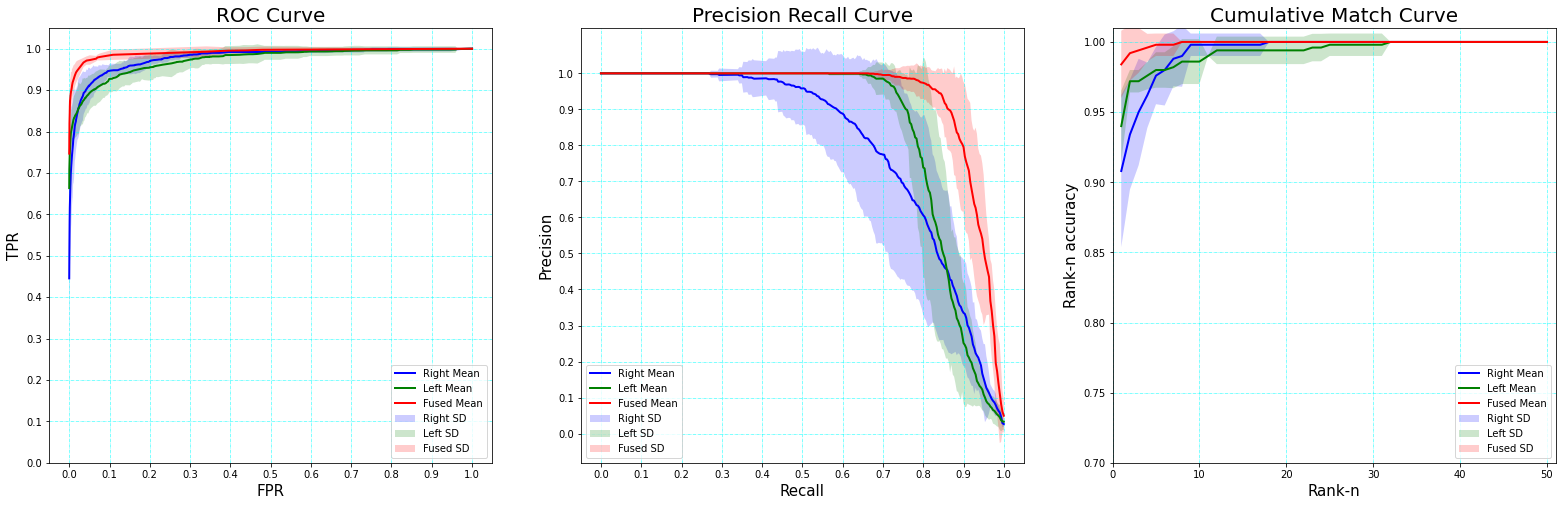

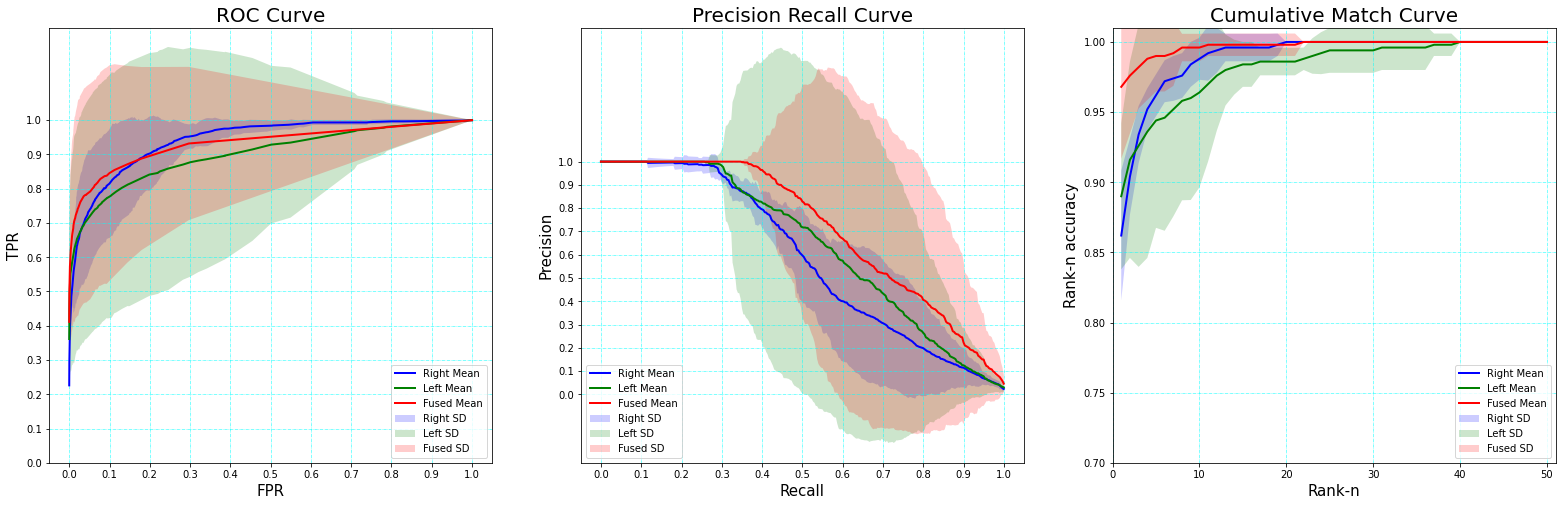

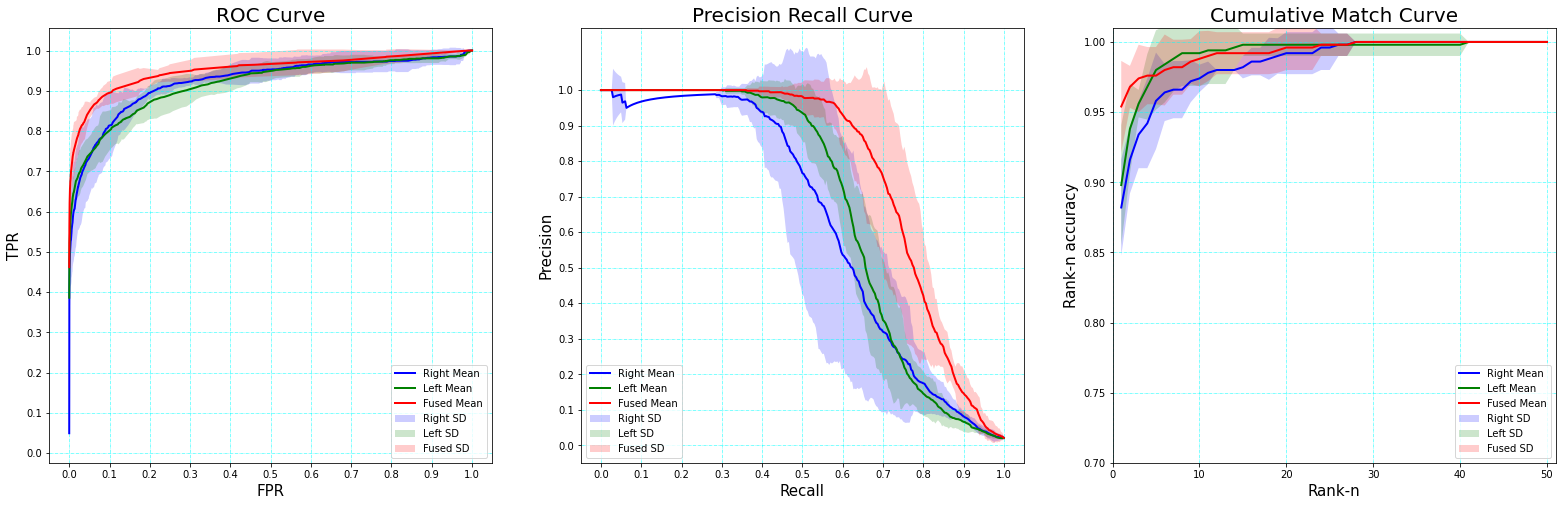

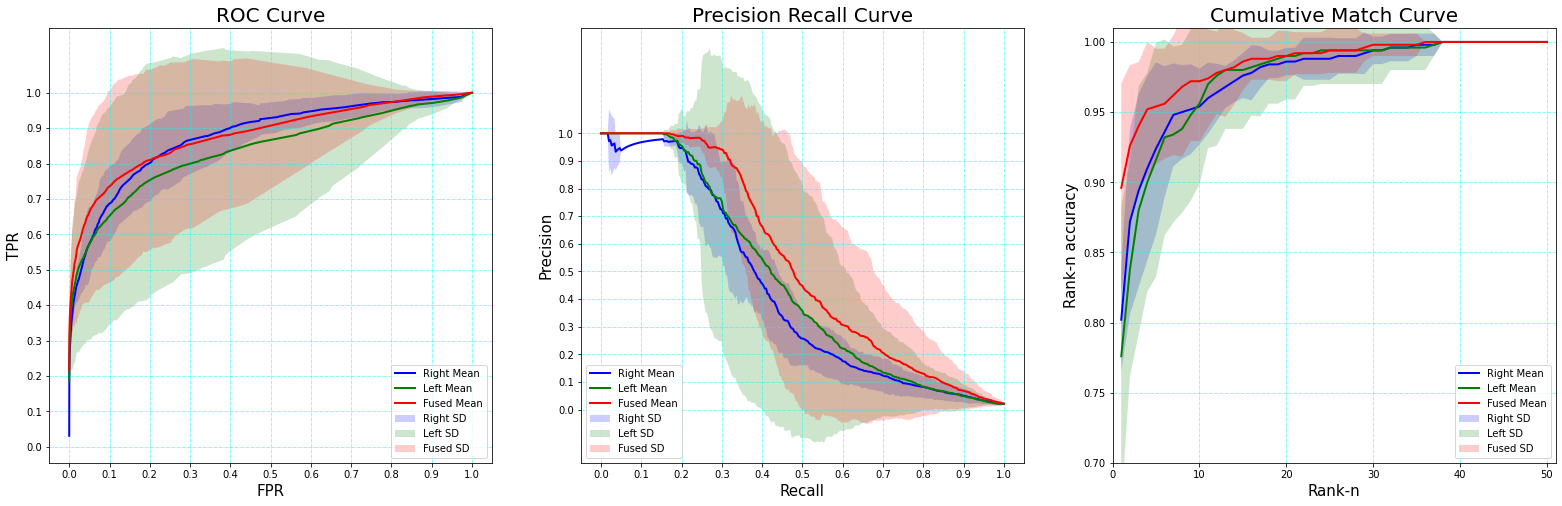

In [ ]:
# For closed set with no occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(closed_fpr_right,closed_tpr_right,closed_recall_right,closed_precision_right,closed_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(closed_fpr_left,closed_tpr_left,closed_recall_left,closed_precision_left,closed_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(closed_fpr_fused,closed_tpr_fused,closed_recall_fused,closed_precision_fused,closed_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("L8_closed_no_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For closed set with occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(occ_closed_fpr_right,occ_closed_tpr_right,occ_closed_recall_right,occ_closed_precision_right,occ_closed_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(occ_closed_fpr_left,occ_closed_tpr_left,occ_closed_recall_left,occ_closed_precision_left,occ_closed_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(occ_closed_fpr_fused,occ_closed_tpr_fused,occ_closed_recall_fused,occ_closed_precision_fused,occ_closed_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("L8_closed_with_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For open set with no occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(open_fpr_right,open_tpr_right,open_recall_right,open_precision_right,open_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(open_fpr_left,open_tpr_left,open_recall_left,open_precision_left,open_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(open_fpr_fused,open_tpr_fused,open_recall_fused,open_precision_fused,open_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("L8_open_no_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For open set with occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(occ_open_fpr_right,occ_open_tpr_right,occ_open_recall_right,occ_open_precision_right,occ_open_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(occ_open_fpr_left,occ_open_tpr_left,occ_open_recall_left,occ_open_precision_left,occ_open_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(occ_open_fpr_fused,occ_open_tpr_fused,occ_open_recall_fused,occ_open_precision_fused,occ_open_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("L8_open_with_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For the case of training with occlusions in the generated triplets during training

In [ ]:
train_occlusions = True; train_margin = 1; train_lr = 0.00005;

In [35]:
closed_cmc_right = []; closed_fpr_right = []; closed_tpr_right = []; closed_precision_right = []; closed_recall_right = []; closed_auroc_right = []; closed_aupr_right = []; closed_eer_right = [];
closed_cmc_left = []; closed_fpr_left = []; closed_tpr_left = []; closed_precision_left = []; closed_recall_left = []; closed_auroc_left = []; closed_aupr_left = []; closed_eer_left = [];
closed_cmc_fused = []; closed_fpr_fused = []; closed_tpr_fused = []; closed_precision_fused = []; closed_recall_fused = []; closed_auroc_fused = []; closed_aupr_fused = []; closed_eer_fused = [];

occ_closed_cmc_right = []; occ_closed_fpr_right = []; occ_closed_tpr_right = []; occ_closed_precision_right = []; occ_closed_recall_right = []; occ_closed_auroc_right = []; occ_closed_aupr_right = []; occ_closed_eer_right = [];
occ_closed_cmc_left = []; occ_closed_fpr_left = []; occ_closed_tpr_left = []; occ_closed_precision_left = []; occ_closed_recall_left = []; occ_closed_auroc_left = []; occ_closed_aupr_left = []; occ_closed_eer_left = [];
occ_closed_cmc_fused = []; occ_closed_fpr_fused = []; occ_closed_tpr_fused = []; occ_closed_precision_fused = []; occ_closed_recall_fused = []; occ_closed_auroc_fused = []; occ_closed_aupr_fused = []; occ_closed_eer_fused = [];

open_cmc_right = []; open_fpr_right = []; open_tpr_right = []; open_precision_right = []; open_recall_right = []; open_auroc_right = []; open_aupr_right = []; open_eer_right = [];
open_cmc_left = []; open_fpr_left = []; open_tpr_left = []; open_precision_left = []; open_recall_left = []; open_auroc_left = []; open_aupr_left = []; open_eer_left = [];
open_cmc_fused = []; open_fpr_fused = []; open_tpr_fused = []; open_precision_fused = []; open_recall_fused = []; open_auroc_fused = []; open_aupr_fused = []; open_eer_fused = [];

occ_open_cmc_right = []; occ_open_fpr_right = []; occ_open_tpr_right = []; occ_open_precision_right = []; occ_open_recall_right = []; occ_open_auroc_right = []; occ_open_aupr_right = []; occ_open_eer_right = [];
occ_open_cmc_left = []; occ_open_fpr_left = []; occ_open_tpr_left = []; occ_open_precision_left = []; occ_open_recall_left = []; occ_open_auroc_left = []; occ_open_aupr_left = []; occ_open_eer_left = [];
occ_open_cmc_fused = []; occ_open_fpr_fused = []; occ_open_tpr_fused = []; occ_open_precision_fused = []; occ_open_recall_fused = []; occ_open_auroc_fused = []; occ_open_aupr_fused = []; occ_open_eer_fused = [];


for run_index in range(num_runs):
  print("Starting with run number: ",run_index+1)

  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Training the network for right ear images: ")  
  num_train_start = 1; num_train_end = 3; 
  train_dataset, val_dataset  = get_train_val_images(all_ear_images,num_train_start,num_train_end,num_channels,num_closed,"right",train_occlusions,False,num_imposters,0.8);
  right_embedding_network, siamese_network = initialize_siamese_model(); siamese_model = SiameseModel(siamese_network, margin=train_margin); 
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate=train_lr,beta_1=0.9,beta_2=0.999,amsgrad=True)); siamese_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
  
  print("Inference for right ear images from the closed set and no occlusions: ")
  cl_emb_r = right_embedding_network(all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < all_right_images.shape[0]:
    cl_emb_r = np.concatenate((cl_emb_r,right_embedding_network(all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,cl_emb_r,num_train,num_test)  
  closed_cmc_right.append(cmc_this)
  closed_fpr_right.append(fpr_this); closed_tpr_right.append(tpr_this); closed_precision_right.append(precision_this); closed_recall_right.append(recall_this) 
  closed_auroc_right.append(auroc_this); closed_aupr_right.append(aupr_this); closed_eer_right.append(eer_this) 

  print("Inference for right ear images from the closed set and with occlusions: ")
  occ_cl_emb_r = right_embedding_network(occ_closed_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_closed_all_right_images.shape[0]:
    occ_cl_emb_r = np.concatenate((occ_cl_emb_r,right_embedding_network(occ_closed_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,occ_cl_emb_r,num_train,num_test)  
  occ_closed_cmc_right.append(cmc_this)
  occ_closed_fpr_right.append(fpr_this); occ_closed_tpr_right.append(tpr_this); occ_closed_precision_right.append(precision_this); occ_closed_recall_right.append(recall_this) 
  occ_closed_auroc_right.append(auroc_this); occ_closed_aupr_right.append(aupr_this); occ_closed_eer_right.append(eer_this) 


  print("Inference for right ear images from the open set and no occlusions: ")
  op_emb_r = right_embedding_network(open_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < open_all_right_images.shape[0]:
    op_emb_r = np.concatenate((op_emb_r,right_embedding_network(open_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,op_emb_r,num_train,num_test)  
  open_cmc_right.append(cmc_this)
  open_fpr_right.append(fpr_this); open_tpr_right.append(tpr_this); open_precision_right.append(precision_this); open_recall_right.append(recall_this) 
  open_auroc_right.append(auroc_this); open_aupr_right.append(aupr_this); open_eer_right.append(eer_this) 


  print("Inference for right ear images from the open set and with occlusions: ")
  occ_op_emb_r = right_embedding_network(occ_open_all_right_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_open_all_right_images.shape[0]:
    occ_op_emb_r = np.concatenate((occ_op_emb_r,right_embedding_network(occ_open_all_right_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,occ_op_emb_r,num_train,num_test)  
  occ_open_cmc_right.append(cmc_this)
  occ_open_fpr_right.append(fpr_this); occ_open_tpr_right.append(tpr_this); occ_open_precision_right.append(precision_this); occ_open_recall_right.append(recall_this) 
  occ_open_auroc_right.append(auroc_this); occ_open_aupr_right.append(aupr_this); occ_open_eer_right.append(eer_this) 

  del train_dataset, val_dataset
  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Training the network for left ear images: ")  
  num_train_start = 6; num_train_end = 8; 
  train_dataset, val_dataset  = get_train_val_images(all_ear_images,num_train_start,num_train_end,num_channels,num_closed,"left",train_occlusions,False,num_imposters,0.8);
  left_embedding_network, siamese_network = initialize_siamese_model(); siamese_model = SiameseModel(siamese_network, margin=train_margin); 
  siamese_model.compile(optimizer=optimizers.Adam(learning_rate=train_lr,beta_1=0.9,beta_2=0.999,amsgrad=True)); siamese_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
  
  print("Inference for left ear images from the closed set and no occlusions: ")
  cl_emb_l = left_embedding_network(all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < all_left_images.shape[0]:
    cl_emb_l = np.concatenate((cl_emb_l,left_embedding_network(all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,cl_emb_l,num_train,num_test)  
  closed_cmc_left.append(cmc_this)
  closed_fpr_left.append(fpr_this); closed_tpr_left.append(tpr_this); closed_precision_left.append(precision_this); closed_recall_left.append(recall_this) 
  closed_auroc_left.append(auroc_this); closed_aupr_left.append(aupr_this); closed_eer_left.append(eer_this) 

  print("Inference for left ear images from the closed set and with occlusions: ")
  occ_cl_emb_l = left_embedding_network(occ_closed_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_closed_all_left_images.shape[0]:
    occ_cl_emb_l = np.concatenate((occ_cl_emb_l,left_embedding_network(occ_closed_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_closed,occ_cl_emb_l,num_train,num_test)  
  occ_closed_cmc_left.append(cmc_this)
  occ_closed_fpr_left.append(fpr_this); occ_closed_tpr_left.append(tpr_this); occ_closed_precision_left.append(precision_this); occ_closed_recall_left.append(recall_this) 
  occ_closed_auroc_left.append(auroc_this); occ_closed_aupr_left.append(aupr_this); occ_closed_eer_left.append(eer_this) 


  print("Inference for left ear images from the open set and no occlusions: ")
  op_emb_l = left_embedding_network(open_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < open_all_left_images.shape[0]:
    op_emb_l = np.concatenate((op_emb_l,left_embedding_network(open_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,op_emb_l,num_train,num_test)  
  open_cmc_left.append(cmc_this)
  open_fpr_left.append(fpr_this); open_tpr_left.append(tpr_this); open_precision_left.append(precision_this); open_recall_left.append(recall_this) 
  open_auroc_left.append(auroc_this); open_aupr_left.append(aupr_this); open_eer_left.append(eer_this) 


  print("Inference for left ear images from the open set and with occlusions: ")
  occ_op_emb_l = left_embedding_network(occ_open_all_left_images[0:inference_batches],training=False).numpy()
  i = inference_batches
  while i < occ_open_all_left_images.shape[0]:
    occ_op_emb_l = np.concatenate((occ_op_emb_l,left_embedding_network(occ_open_all_left_images[i:i+inference_batches],training=False).numpy()))
    i = i + inference_batches  
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves(num_persons-num_closed,occ_op_emb_l,num_train,num_test)  
  occ_open_cmc_left.append(cmc_this)
  occ_open_fpr_left.append(fpr_this); occ_open_tpr_left.append(tpr_this); occ_open_precision_left.append(precision_this); occ_open_recall_left.append(recall_this) 
  occ_open_auroc_left.append(auroc_this); occ_open_aupr_left.append(aupr_this); occ_open_eer_left.append(eer_this) 

  del train_dataset, val_dataset
  # ------------------------------------------------------------------------------------------------------------------------------------------------------------------
  print("Combining the left and right ear embeddings in order to get the results of score level fusion: ")  

  print("Inference for fused ear images from the closed set and no occlusions: ")
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_closed,cl_emb_r,cl_emb_l,num_train,num_test,0.5)  
  closed_cmc_fused.append(cmc_this)
  closed_fpr_fused.append(fpr_this); closed_tpr_fused.append(tpr_this); closed_precision_fused.append(precision_this); closed_recall_fused.append(recall_this) 
  closed_auroc_fused.append(auroc_this); closed_aupr_fused.append(aupr_this); closed_eer_fused.append(eer_this) 

  print("Inference for fused ear images from the closed set and with occlusions: ")

  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_closed,occ_cl_emb_r,occ_cl_emb_l,num_train,num_test,0.5)  
  occ_closed_cmc_fused.append(cmc_this)
  occ_closed_fpr_fused.append(fpr_this); occ_closed_tpr_fused.append(tpr_this); occ_closed_precision_fused.append(precision_this); occ_closed_recall_fused.append(recall_this) 
  occ_closed_auroc_fused.append(auroc_this); occ_closed_aupr_fused.append(aupr_this); occ_closed_eer_fused.append(eer_this) 


  print("Inference for fused ear images from the open set and no occlusions: ")

  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_persons-num_closed,op_emb_r,op_emb_l,num_train,num_test,0.5)
  open_cmc_fused.append(cmc_this)
  open_fpr_fused.append(fpr_this); open_tpr_fused.append(tpr_this); open_precision_fused.append(precision_this); open_recall_fused.append(recall_this) 
  open_auroc_fused.append(auroc_this); open_aupr_fused.append(aupr_this); open_eer_fused.append(eer_this) 


  print("Inference for fused ear images from the open set and with occlusions: ")
  
  cmc_this, fpr_this,tpr_this,th_1,precision_this,recall_this,th_2,auroc_this,aupr_this,eer_this = get_metric_curves_fused(num_persons-num_closed,occ_op_emb_r,occ_op_emb_l,num_train,num_test,0.5) 
  occ_open_cmc_fused.append(cmc_this)
  occ_open_fpr_fused.append(fpr_this); occ_open_tpr_fused.append(tpr_this); occ_open_precision_fused.append(precision_this); occ_open_recall_fused.append(recall_this) 
  occ_open_auroc_fused.append(auroc_this); occ_open_aupr_fused.append(aupr_this); occ_open_eer_fused.append(eer_this) 

  print("Finished with run number: ",run_index+1)
  print("**************************************************************************************************************************\n")

Starting with run number:  1
Training the network for right ear images: 
Total number of images in the folder:  150
Number of genuine pairs in total:  150
Number of imposter pairs in total:  11025
Creating a list that records the triplets which will be used for training:


100%|██████████| 150/150 [00:00<00:00, 544.05it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:19<00:00, 28.94it/s]


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 5 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 593ms/step - loss: 1.5650 - val_loss: 0.8041
Epoch 2/20
60/60 [==============================] - 18s 307ms/step - loss: 0.4683 - val_loss: 0.3011
Epoch 3/20
60/60 [==============================] - 18s 307ms/step - loss: 0.2703 - val_loss: 0.1838
Epoch 4/20
60/60 [==============================] - 18s 306ms/step - loss: 0.1492 - val_loss: 0.1963
Epoch 5/20
60/60 [==============================] - 18s 306ms/step - loss: 0.1316 - val_loss: 0.03

100%|██████████| 150/150 [00:00<00:00, 511.04it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:23<00:00, 28.49it/s]


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 6 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 571ms/step - loss: 0.9290 - val_loss: 0.3944
Epoch 2/20
60/60 [==============================] - 18s 307ms/step - loss: 0.2815 - val_loss: 0.1403
Epoch 3/20
60/60 [==============================] - 19s 310ms/step - loss: 0.1861 - val_loss: 0.1247
Epoch 4/20
60/60 [==============================] - 18s 308ms/step - loss: 0.0986 - val_loss: 0.0359
Epoch 5/20
60/60 [==============================] - 18s 308ms/step - loss: 0.0726 - val_loss: 0.01

100%|██████████| 150/150 [00:00<00:00, 539.30it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:17<00:00, 29.11it/s]


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 7 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 571ms/step - loss: 2.4903 - val_loss: 0.8439
Epoch 2/20
60/60 [==============================] - 18s 307ms/step - loss: 0.6593 - val_loss: 0.6012
Epoch 3/20
60/60 [==============================] - 19s 308ms/step - loss: 0.4254 - val_loss: 0.2171
Epoch 4/20
60/60 [==============================] - 18s 306ms/step - loss: 0.1952 - val_loss: 0.2524
Epoch 5/20
60/60 [==============================] - 18s 307ms/step - loss: 0.1056 - val_loss: 0.15

100%|██████████| 150/150 [00:00<00:00, 523.43it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:19<00:00, 28.86it/s]


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 8 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 586ms/step - loss: 1.5009 - val_loss: 0.3876
Epoch 2/20
60/60 [==============================] - 18s 305ms/step - loss: 0.3685 - val_loss: 0.3568
Epoch 3/20
60/60 [==============================] - 18s 302ms/step - loss: 0.2374 - val_loss: 0.1379
Epoch 4/20
60/60 [==============================] - 18s 303ms/step - loss: 0.1592 - val_loss: 0.1079
Epoch 5/20
60/60 [==============================] - 18s 303ms/step - loss: 0.0871 - val_loss: 0.06

100%|██████████| 150/150 [00:00<00:00, 519.06it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:22<00:00, 28.57it/s]


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_1  (None, 128)              562343    
 9 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 559ms/step - loss: 2.4666 - val_loss: 1.2105
Epoch 2/20
60/60 [==============================] - 18s 295ms/step - loss: 0.6017 - val_loss: 0.3731
Epoch 3/20
60/60 [==============================] - 18s 296ms/step - loss: 0.3890 - val_loss: 0.2547
Epoch 4/20
60/60 [==============================] - 18s 296ms/step - loss: 0.2243 - val_loss: 0.2888
Epoch 5/20
60/60 [==============================] - 18s 298ms/step - loss: 0.1109 - val_loss: 0.10

100%|██████████| 150/150 [00:00<00:00, 537.87it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:20<00:00, 28.81it/s]


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_2  (None, 128)              562343    
 0 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 65s 573ms/step - loss: 3.7566 - val_loss: 0.9754
Epoch 2/20
60/60 [==============================] - 19s 309ms/step - loss: 0.9783 - val_loss: 0.5184
Epoch 3/20
60/60 [==============================] - 19s 310ms/step - loss: 0.3266 - val_loss: 0.3034
Epoch 4/20
60/60 [==============================] - 18s 309ms/step - loss: 0.2397 - val_loss: 0.3404
Epoch 5/20
60/60 [==============================] - 18s 308ms/step - loss: 0.1984 - val_loss: 0.20

100%|██████████| 150/150 [00:00<00:00, 548.00it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:17<00:00, 29.11it/s]


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_2  (None, 128)              562343    
 1 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 64s 582ms/step - loss: 1.9036 - val_loss: 0.8696
Epoch 2/20
60/60 [==============================] - 18s 297ms/step - loss: 0.5378 - val_loss: 0.3498
Epoch 3/20
60/60 [==============================] - 18s 298ms/step - loss: 0.3565 - val_loss: 0.1433
Epoch 4/20
60/60 [==============================] - 18s 298ms/step - loss: 0.1565 - val_loss: 0.1142
Epoch 5/20
60/60 [==============================] - 18s 299ms/step - loss: 0.1266 - val_loss: 0.20

100%|██████████| 150/150 [00:00<00:00, 482.69it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:28<00:00, 27.98it/s]


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_2  (None, 128)              562343    
 2 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 571ms/step - loss: 1.1652 - val_loss: 0.3457
Epoch 2/20
60/60 [==============================] - 18s 308ms/step - loss: 0.3455 - val_loss: 0.3960
Epoch 3/20
60/60 [==============================] - 18s 308ms/step - loss: 0.2039 - val_loss: 0.2137
Epoch 4/20
60/60 [==============================] - 18s 309ms/step - loss: 0.1646 - val_loss: 0.1651
Epoch 5/20
60/60 [==============================] - 18s 307ms/step - loss: 0.1088 - val_loss: 0.06

100%|██████████| 150/150 [00:00<00:00, 547.70it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:17<00:00, 29.09it/s]


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_2  (None, 128)              562343    
 3 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 578ms/step - loss: 1.7364 - val_loss: 0.5447
Epoch 2/20
60/60 [==============================] - 19s 309ms/step - loss: 0.4620 - val_loss: 0.1903
Epoch 3/20
60/60 [==============================] - 19s 310ms/step - loss: 0.2604 - val_loss: 0.1515
Epoch 4/20
60/60 [==============================] - 18s 310ms/step - loss: 0.1039 - val_loss: 0.1260
Epoch 5/20
60/60 [==============================] - 18s 308ms/step - loss: 0.1528 - val_loss: 0.11

100%|██████████| 150/150 [00:00<00:00, 517.74it/s]


Generating data which has the images arranged as triplets, this can be fed into the model, for training:


100%|██████████| 7500/7500 [04:18<00:00, 29.03it/s]


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual__scat_net__block_2  (None, 128)              562343    
 4 (Residual_ScatNet_Block)                                      
                                                                 
Total params: 562,343
Trainable params: 562,223
Non-trainable params: 120
_________________________________________________________________
None
Epoch 1/20
60/60 [==============================] - 66s 582ms/step - loss: 1.7498 - val_loss: 0.7150
Epoch 2/20
60/60 [==============================] - 19s 311ms/step - loss: 0.5357 - val_loss: 0.4749
Epoch 3/20
60/60 [==============================] - 19s 309ms/step - loss: 0.3208 - val_loss: 0.2782
Epoch 4/20
60/60 [==============================] - 19s 312ms/step - loss: 0.1907 - val_loss: 0.1372
Epoch 5/20
60/60 [==============================] - 19s 309ms/step - loss: 0.1980 - val_loss: 0.12

Results for all the 4 cases of occlusion/no-occlusion and closed set/open set

In [36]:
print("Closed set and no occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(closed_cmc_right,closed_fpr_right,closed_tpr_right,closed_precision_right,closed_recall_right,closed_auroc_right,closed_aupr_right,closed_eer_right,3,"Right",3,3,1)
txt_l = display_results(closed_cmc_left,closed_fpr_left,closed_tpr_left,closed_precision_left,closed_recall_left,closed_auroc_left,closed_aupr_left,closed_eer_left,3,"Left",3,3,4)
txt_f = display_results(closed_cmc_fused,closed_fpr_fused,closed_tpr_fused,closed_precision_fused,closed_recall_fused,closed_auroc_fused,closed_aupr_fused,closed_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Closed set and with occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(occ_closed_cmc_right,occ_closed_fpr_right,occ_closed_tpr_right,occ_closed_precision_right,occ_closed_recall_right,occ_closed_auroc_right,occ_closed_aupr_right,occ_closed_eer_right,3,"Right",3,3,1)
txt_l = display_results(occ_closed_cmc_left,occ_closed_fpr_left,occ_closed_tpr_left,occ_closed_precision_left,occ_closed_recall_left,occ_closed_auroc_left,occ_closed_aupr_left,occ_closed_eer_left,3,"Left",3,3,4)
txt_f = display_results(occ_closed_cmc_fused,occ_closed_fpr_fused,occ_closed_tpr_fused,occ_closed_precision_fused,occ_closed_recall_fused,occ_closed_auroc_fused,occ_closed_aupr_fused,occ_closed_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Open set and no occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(open_cmc_right,open_fpr_right,open_tpr_right,open_precision_right,open_recall_right,open_auroc_right,open_aupr_right,open_eer_right,3,"Right",3,3,1)
txt_l = display_results(open_cmc_left,open_fpr_left,open_tpr_left,open_precision_left,open_recall_left,open_auroc_left,open_aupr_left,open_eer_left,3,"Left",3,3,4)
txt_f = display_results(open_cmc_fused,open_fpr_fused,open_tpr_fused,open_precision_fused,open_recall_fused,open_auroc_fused,open_aupr_fused,open_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

print("Open set and with occlusion: ")

#plt.figure(figsize = (20,20))

txt_r = display_results(occ_open_cmc_right,occ_open_fpr_right,occ_open_tpr_right,occ_open_precision_right,occ_open_recall_right,occ_open_auroc_right,occ_open_aupr_right,occ_open_eer_right,3,"Right",3,3,1)
txt_l = display_results(occ_open_cmc_left,occ_open_fpr_left,occ_open_tpr_left,occ_open_precision_left,occ_open_recall_left,occ_open_auroc_left,occ_open_aupr_left,occ_open_eer_left,3,"Left",3,3,4)
txt_f = display_results(occ_open_cmc_fused,occ_open_fpr_fused,occ_open_tpr_fused,occ_open_precision_fused,occ_open_recall_fused,occ_open_auroc_fused,occ_open_aupr_fused,occ_open_eer_fused,3,"Fused",3,3,7)

#plt.savefig("dummy1.pdf", format="pdf", bbox_inches="tight")
#plt.show()

print(txt_r)
print(txt_l)
print(txt_f)  

Closed set and no occlusion: 
Right$ & $97.601\pm0.375$ & $83.19\pm2.655$ & $7.716\pm0.59$ & $90.2\pm1.6$ & $97.6\pm0.49\  \hline
Left$ & $98.019\pm0.335$ & $85.494\pm1.511$ & $7.652\pm0.923$ & $93.4\pm1.625$ & $97.6\pm0.8\  \hline
Fused$ & $99.513\pm0.075$ & $94.212\pm0.245$ & $3.645\pm0.028$ & $97.8\pm1.166$ & $99.8\pm0.4\  \hline
Closed set and with occlusion: 
Right$ & $97.556\pm0.34$ & $80.559\pm2.725$ & $7.516\pm0.607$ & $89.4\pm1.02$ & $97.4\pm0.8\  \hline
Left$ & $97.756\pm0.186$ & $83.897\pm1.477$ & $8.174\pm0.495$ & $92.2\pm2.227$ & $97.8\pm0.748\  \hline
Fused$ & $99.442\pm0.114$ & $93.003\pm0.483$ & $4.09\pm0.318$ & $98.0\pm0.894$ & $99.4\pm0.49\  \hline
Open set and no occlusion: 
Right$ & $92.491\pm0.673$ & $65.501\pm2.253$ & $13.267\pm0.975$ & $87.0\pm2.828$ & $94.2\pm0.748\  \hline
Left$ & $93.652\pm1.042$ & $68.971\pm1.282$ & $13.664\pm1.27$ & $90.8\pm1.72$ & $97.8\pm1.166\  \hline
Fused$ & $95.793\pm0.296$ & $80.424\pm1.221$ & $9.684\pm0.712$ & $94.8\pm1.166$ & $96.8\

# Plotting the Metric Curves

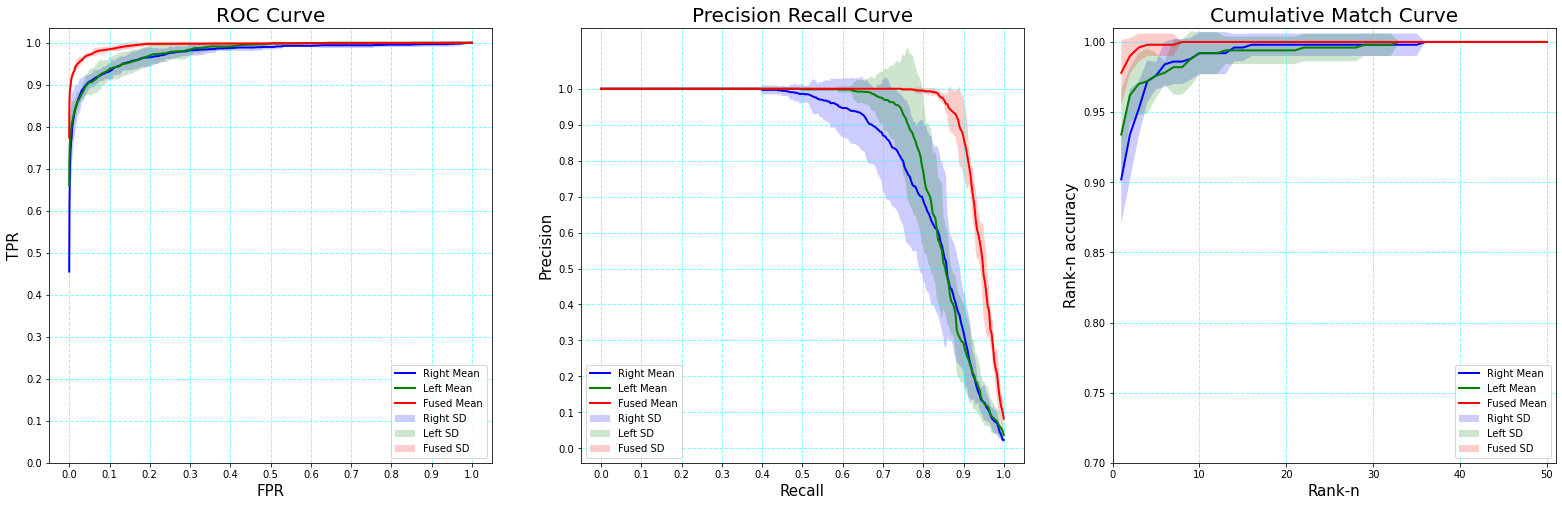

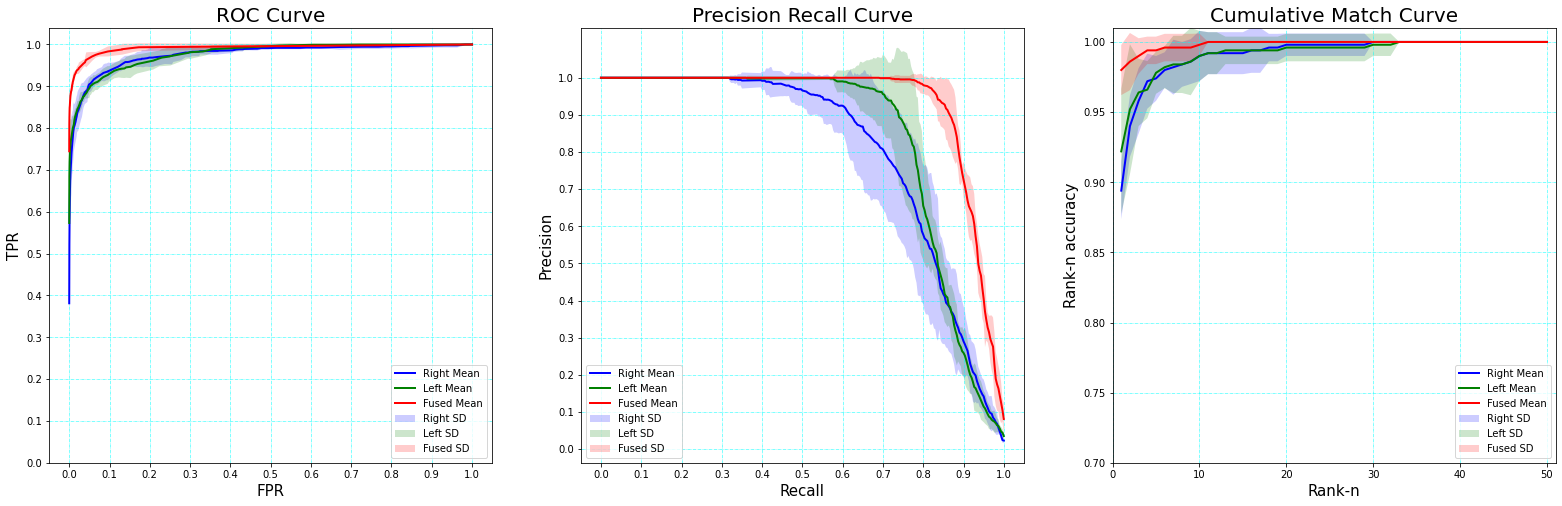

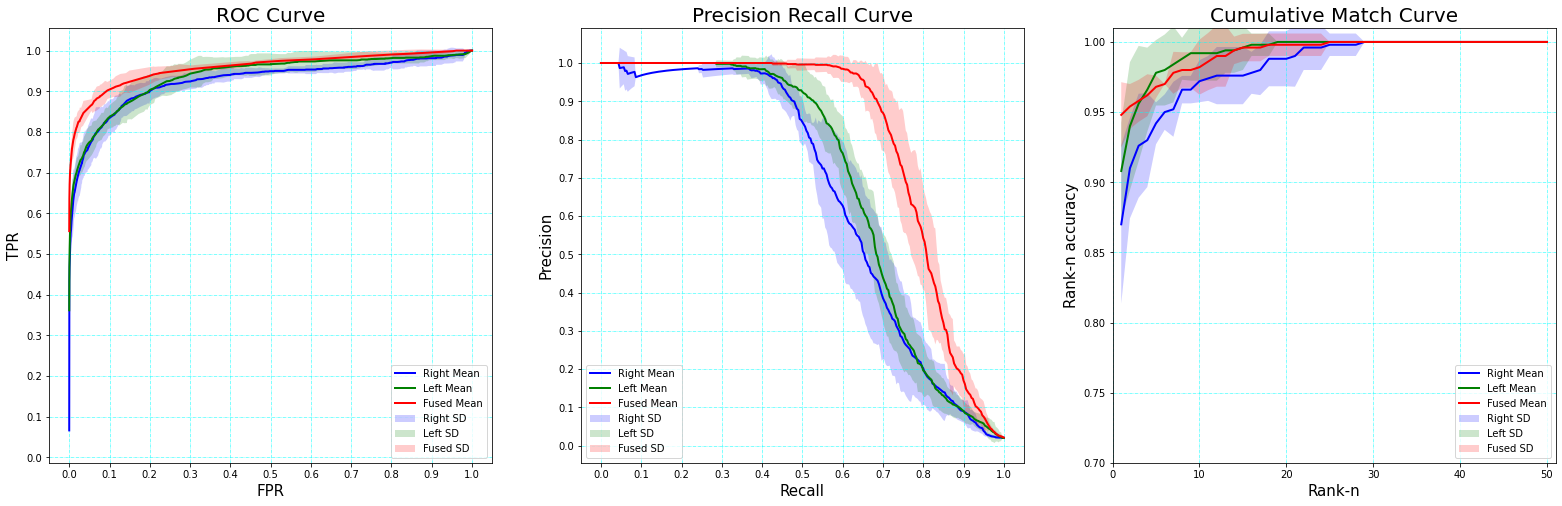

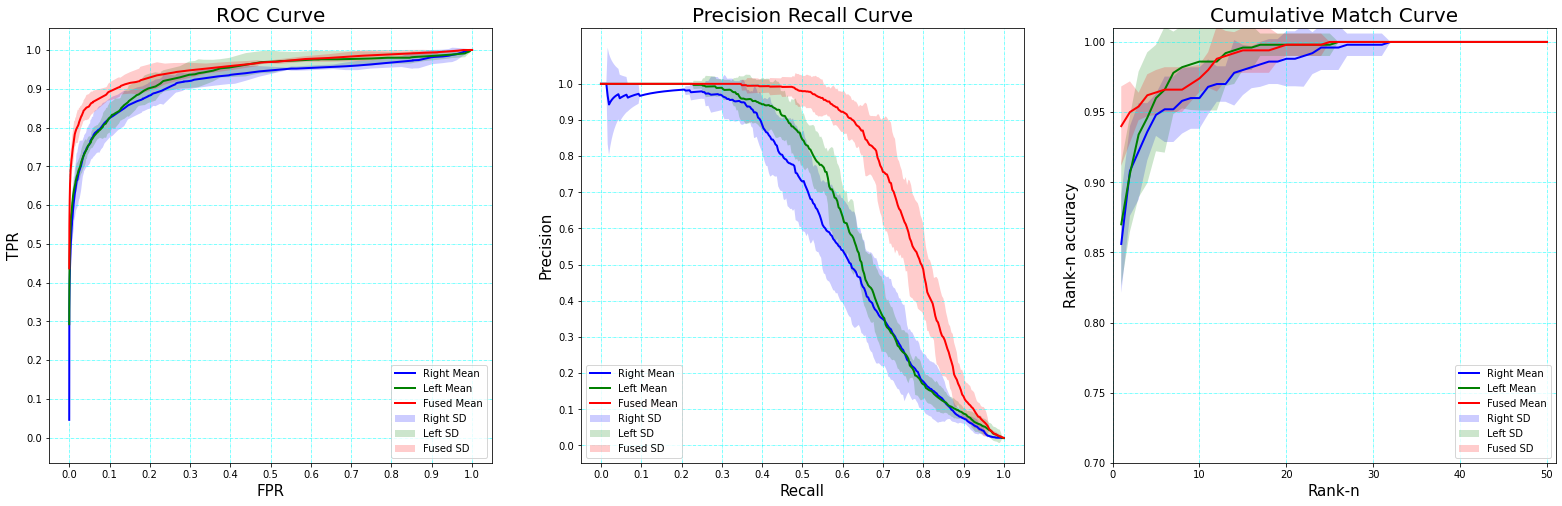

In [40]:
# For closed set with no occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(closed_fpr_right,closed_tpr_right,closed_recall_right,closed_precision_right,closed_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(closed_fpr_left,closed_tpr_left,closed_recall_left,closed_precision_left,closed_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(closed_fpr_fused,closed_tpr_fused,closed_recall_fused,closed_precision_fused,closed_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("train_L8_closed_no_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For closed set with occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(occ_closed_fpr_right,occ_closed_tpr_right,occ_closed_recall_right,occ_closed_precision_right,occ_closed_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(occ_closed_fpr_left,occ_closed_tpr_left,occ_closed_recall_left,occ_closed_precision_left,occ_closed_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(occ_closed_fpr_fused,occ_closed_tpr_fused,occ_closed_recall_fused,occ_closed_precision_fused,occ_closed_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("train_L8_closed_with_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For open set with no occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(open_fpr_right,open_tpr_right,open_recall_right,open_precision_right,open_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(open_fpr_left,open_tpr_left,open_recall_left,open_precision_left,open_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(open_fpr_fused,open_tpr_fused,open_recall_fused,open_precision_fused,open_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("train_L8_open_no_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()

# For open set with occlusions
fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r = return_combined_plot_curves(occ_open_fpr_right,occ_open_tpr_right,occ_open_recall_right,occ_open_precision_right,occ_open_cmc_right)
fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l = return_combined_plot_curves(occ_open_fpr_left,occ_open_tpr_left,occ_open_recall_left,occ_open_precision_left,occ_open_cmc_left)
fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f = return_combined_plot_curves(occ_open_fpr_fused,occ_open_tpr_fused,occ_open_recall_fused,occ_open_precision_fused,occ_open_cmc_fused)

plt.figure(figsize = (27,8))
plot_combined_curves(fpr_r,all_tpr_mean_r,all_tpr_std_r,recall_r,all_precision_mean_r,all_precision_std_r,cmc_x_axis_r,cmc_mean_r,cmc_std_r,'b',
                         fpr_l,all_tpr_mean_l,all_tpr_std_l,recall_l,all_precision_mean_l,all_precision_std_l,cmc_x_axis_l,cmc_mean_l,cmc_std_l,'g',
                         fpr_f,all_tpr_mean_f,all_tpr_std_f,recall_f,all_precision_mean_f,all_precision_std_f,cmc_x_axis_f,cmc_mean_f,cmc_std_f,'r')

plt.savefig("train_L8_open_with_occlusions.pdf", format="pdf", bbox_inches="tight")
plt.show()